<br><br><br><br><br><br><br>

<center>МИНИСТЕРСТВО НАУКИ И ВЫСШЕГО ОБРАЗОВАНИЯ РОССИЙСКОЙ ФЕДЕРАЦИИ</center>
<br>

<center>Федеральное государственное автономное образовательное учреждение высшего образования</center>
<center>«Национальный исследовательский Нижегородский государственный университет им. Н.И. Лобачевского» (ННГУ)</center>
<br>

<center>Институт информационных технологий, математики и механики</center>
<br>
<center>Кафедра алгебры, геометрии и дискретной математики</center>
<br>

<h2><center>Отчет по работе</center></h2>
<h1><center>«Использование эластичных графов для визуализации и анализа данных»</center></h1>

<br><br><br><br><br><br>

<div style="text-align: right">
    <div> <b>Выполнил:</b> </div>
    <div> студент группы 381803-1 </div>
    <div> Герасимов М. А. </div>
    <br>
    <div><b>Проверил:</b></div>
    <div>директор ИИТММ, заведующий кафедрой АГДМ</div>
    <div>Золотых. Н. Ю.</div>
</div>

<br><br><br><br><br><br><br><br><br><br><br><br>

<center>Нижний Новгород</center>
<center>2021</center>
<br>

# Введение

Данная работа - вторая часть совместной работы по визуализации данных с целью выделения в них различных кластеров и возможных путей развития сердечно-сосудистых заболеваний. В качестве наборов данных взяты две обработанные с помощью сегментирующей нейронной сети базы данных ЭКГ, содержащие более 20000 записей для различных пациентов (результат первой части работы). В этой части будут разобраны различные способы пост-обработки наборов данных для их подготовки к визуализации, и затем будет проведена сама визуализация с последующим анализом. Для визуализации будет использован модуль ElPiGraph, позволяющий строить эластичные графы.

# Постановка задачи

1. Подготовить полученную из первой части работы базу данных для визуализации,
2. Визуализировать данные с помощью ElPiGraph,
3. Проанализировать полученные результаты.

# Работа над программой

Для выполнения работы используются базы данных CSPC2018 и PTB-XL, предварительно обработанные сегментирующей нейронной сетью. После обработки базы представляют собой таблицы, в который каждой строке соответствуют пациент, а каждому столбцу - определенная характеристика (признак) пациента (возраст, рост, сердечный ритм и т.д.). Также в каждой базе данных есть столбец или несколько столбцов, указывающих на диагноз. В базе данных CSPC2018 24000 строк, а в базе PTB-XL - 21837 строк.



## 1. Обработка данных

Первый этап - обработка данных. Предварительно каждая из баз данных разбивается на 4: первая остается без изменений, во второй удаляются все здоровые пациенты, в третьей удаляются столбцы, отвечающие за диагнозы, а четвертая является комбинацией второй и третьей. Такой подход позволит отследить влияние здоровых пациентов и диагнозов на построение эластичного графа.

Импортируем необходимые модули:

In [101]:
from __future__ import division, print_function, unicode_literals

import sys
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
import IPython as IPy
import sklearn as skl
from sklearn.model_selection import train_test_split

import os
import tarfile
import urllib
import pickle

import joblib

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [102]:
from clintraj_qi import *
from clintraj_optiscale import *
from clintraj_eltree import *
from clintraj_util import *
import scipy.stats

In [103]:
def save_obj(obj, name):
    os.makedirs("obj/Test", exist_ok=True)
    with open('obj/Test/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('obj/Test/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

### База данных на основе CSPC2018

In [104]:
cspc2018 = pd.read_csv('../datasets/cspc2018.csv', sep=',')
cspc2018

index  Qrst_dur  P_Q_duration  Q_T_duration  T_duration  P_duration  \
0          0  0.076632           NaN      0.279263    0.123100         NaN   
1          1  0.107158           NaN      0.298000    0.112200         NaN   
2          2  0.082800           NaN      0.284947    0.108200         NaN   
3          3  0.081500           NaN      0.314706    0.142556         NaN   
4          4  0.075053           NaN      0.268421    0.084762         NaN   
...      ...       ...           ...           ...         ...         ...   
23995  23995  0.104125           0.0      0.376000    0.153500    0.071875   
23996  23996  0.100500           0.0      0.413750    0.193625    0.080750   
23997  23997  0.094750           0.0      0.420625    0.190500    0.087500   
23998  23998  0.091500           0.0      0.416125    0.178625    0.093750   
23999  23999  0.086625           0.0      0.415625    0.177250    0.099625   

       Heart_rate  f_label  sex  age        QRSA       Q_av         R_av  \
0      171.184023        5    0   74 -596.758874   3.616371  1864.425542   
1      187.826087        1    0   74 -790.003412   5.422741  1844.263848   
2      186.244078        2    0   74 -230.210919  10.927699  1840.033096   
3      185.546875        2    0   74  685.091725   3.258911  1846.318812   
4      170.239596        7    0   74 -214.589496   3.348546  1880.346540   
...           ...      ...  ...  ...         ...        ...          ...   
23995   75.942958        0    1   61   31.864414   4.296980  2247.126398   
23996   75.598488        0    1   61  -34.948739   4.186152  2250.085698   
23997   75.062552        0    1   61  -98.447443   5.704861  2250.611111   
23998   74.775673        0    1   61 -111.225219   5.864009  2255.627784   
23999   74.300338        0    1   61  -99.083990   5.573171  2255.590854   

              S_av  
0      1860.809172  
1      1838.841108  
2      1829.105397  
3      1843.059901  
4      1876.997994  
...            ...  
23995  2242.829418  
23996  2245.899546  
23997  2244.906250  
23998  2249.763775  
23999  2250.017683  

[24000 rows x 14 columns]

In [105]:
cspc2018_wo_index = cspc2018.drop('index', axis=1)
print(f"Количество дубликатов: {len(cspc2018_wo_index.loc[cspc2018_wo_index.duplicated(), :].index)}")

Количество дубликатов: 0


Оценим количество пустых клеток в столбцах.

In [106]:
for col in cspc2018:
    print(f'{col}: {cspc2018[col].isna().sum()} NaN vals')

index: 0 NaN vals
Qrst_dur: 8 NaN vals
P_Q_duration: 3103 NaN vals
Q_T_duration: 14 NaN vals
T_duration: 13 NaN vals
P_duration: 3082 NaN vals
Heart_rate: 10 NaN vals
f_label: 0 NaN vals
sex: 0 NaN vals
age: 0 NaN vals
QRSA: 0 NaN vals
Q_av: 8 NaN vals
R_av: 8 NaN vals
S_av: 8 NaN vals


In [107]:
quantify_nans(cspc2018)

Missing values 6254 (2.0044871794871795%)
Number of complete rows: 19325 (80.52083333333333%)


Узнаем примерное распределение диагнозов (0 - здоровые пациенты, >0 - пациенты с одним из классов аритмии в диагнозе).

In [108]:
cspc2018['f_label'].value_counts()

0    17123
5     1695
2     1098
1      918
8      826
3      704
7      653
6      574
4      207
9      202
Name: f_label, dtype: int64

Перемешаем строчки нашего датасета в случайном порядке.

In [109]:
cspc2018 = cspc2018.sample(frac=1).reset_index(drop=True)
cspc2018

index  Qrst_dur  P_Q_duration  Q_T_duration  T_duration  P_duration  \
0       7683  0.094250      0.188750      0.377750    0.167000    0.104444   
1       1769  0.076121      0.144906      0.399636    0.195758    0.084719   
2       3633  0.104833      0.218000      0.378833    0.158000         NaN   
3      10370  0.102545      0.181091      0.321091    0.119818    0.108167   
4       5031  0.081000      0.158400      0.370889    0.169600    0.095800   
...      ...       ...           ...           ...         ...         ...   
23995  20451  0.078435      0.139000      0.403565    0.179565    0.065600   
23996  16314  0.129111      0.151429      0.366222    0.163636    0.078250   
23997  22389  0.088571      0.213200      0.395286    0.233143    0.085857   
23998  10223  0.105538      0.132889      0.355500    0.187833    0.077667   
23999  21199  0.084545      0.204364      0.382545    0.191636    0.100909   

       Heart_rate  f_label  sex  age         QRSA      Q_av         R_av  \
0       67.329272        0    0   73   217.207931  4.554913  1243.933526   
1       91.030040        7    1   49   238.946978  2.850998  2418.535330   
2      100.533130        3    0   85  1350.435840  5.139692  4246.555877   
3       97.991181        0    1   64  -440.791037  3.277441  6806.163129   
4       80.118694        6    1   63   -27.787808  5.622896  1996.892256   
...           ...      ...  ...  ...          ...       ...          ...   
23995   74.719801        0    0   49   -72.008792  6.628603  1275.730599   
23996   83.145678        0    0   75  -376.061688  7.522436  1218.600427   
23997   77.006615        0    1   76   727.286106  4.896169  6869.056164   
23998  104.347826        0    0   55    79.782808  3.683526  1261.222543   
23999   69.816151        0    1   72  -606.491068  4.644628  1343.481405   

              S_av  
0      1239.378613  
1      2415.684332  
2      4241.416185  
3      6802.885688  
4      1991.269360  
...            ...  
23995  1269.101996  
23996  1211.077991  
23997  6864.159994  
23998  1257.539017  
23999  1338.836777  

[24000 rows x 14 columns]

Создадим 3 новых датасета: датасет без учета здоровых пациентов, датасет без учета диагнозов и датасет, комбинирующий предыдущие два.

In [110]:
cspc2018_unhealthy = cspc2018.drop(cspc2018[(cspc2018['f_label'] == 0)].index).reset_index(drop=True)
cspc2018_raw = cspc2018.drop(['f_label'], axis=1)
cspc2018_raw_unhealthy = cspc2018.drop(['f_label'], axis=1)

Датасет без учета здоровых пациентов:

In [111]:
cspc2018_unhealthy

index  Qrst_dur  P_Q_duration  Q_T_duration  T_duration  P_duration  \
0      1769  0.076121      0.144906      0.399636    0.195758    0.084719   
1      3633  0.104833      0.218000      0.378833    0.158000         NaN   
2      5031  0.081000      0.158400      0.370889    0.169600    0.095800   
3      5362  0.076667      0.178611      0.339333    0.170667    0.070909   
4      4829  0.093103      0.127667      0.345862    0.148069    0.071778   
...     ...       ...           ...           ...         ...         ...   
6872    630  0.093467      0.144571      0.395867    0.187625    0.081000   
6873    240  0.078444      0.109667      0.348444    0.161263    0.080222   
6874   2990  0.091223      0.144667      0.307168    0.117518    0.064000   
6875   4325  0.069500           NaN      0.268625    0.114000         NaN   
6876   6032  0.093400           NaN      0.281625    0.124706         NaN   

      Heart_rate  f_label  sex  age         QRSA      Q_av         R_av  \
0      91.030040        7    1   49   238.946978  2.850998  2418.535330   
1     100.533130        3    0   85  1350.435840  5.139692  4246.555877   
2      80.118694        6    1   63   -27.787808  5.622896  1996.892256   
3      98.331347        7    1   70  2195.002813  3.259835  1297.001830   
4      97.759674        5    1   74   229.359864  2.399576  1940.652051   
...          ...      ...  ...  ...          ...       ...          ...   
6872   69.056232        6    0   76  -191.114046  4.050000  1279.754651   
6873   67.841703        7    0   64    85.942200  3.138667  1234.617333   
6874  139.080189        6    1   63   201.912001  4.726998  1234.969080   
6875  132.860939        5    1   52   742.566737  3.703008  2413.514411   
6876  191.018767        5    1   78  -598.530183  4.173719  1318.232739   

             S_av  
0     2415.684332  
1     4241.416185  
2     1991.269360  
3     1293.741995  
4     1938.252475  
...           ...  
6872  1275.704651  
6873  1231.478667  
6874  1230.242081  
6875  2409.811404  
6876  1314.059020  

[6877 rows x 14 columns]

Датасет без учета диагнозов:

In [112]:
cspc2018_raw

index  Qrst_dur  P_Q_duration  Q_T_duration  T_duration  P_duration  \
0       7683  0.094250      0.188750      0.377750    0.167000    0.104444   
1       1769  0.076121      0.144906      0.399636    0.195758    0.084719   
2       3633  0.104833      0.218000      0.378833    0.158000         NaN   
3      10370  0.102545      0.181091      0.321091    0.119818    0.108167   
4       5031  0.081000      0.158400      0.370889    0.169600    0.095800   
...      ...       ...           ...           ...         ...         ...   
23995  20451  0.078435      0.139000      0.403565    0.179565    0.065600   
23996  16314  0.129111      0.151429      0.366222    0.163636    0.078250   
23997  22389  0.088571      0.213200      0.395286    0.233143    0.085857   
23998  10223  0.105538      0.132889      0.355500    0.187833    0.077667   
23999  21199  0.084545      0.204364      0.382545    0.191636    0.100909   

       Heart_rate  sex  age         QRSA      Q_av         R_av         S_av  
0       67.329272    0   73   217.207931  4.554913  1243.933526  1239.378613  
1       91.030040    1   49   238.946978  2.850998  2418.535330  2415.684332  
2      100.533130    0   85  1350.435840  5.139692  4246.555877  4241.416185  
3       97.991181    1   64  -440.791037  3.277441  6806.163129  6802.885688  
4       80.118694    1   63   -27.787808  5.622896  1996.892256  1991.269360  
...           ...  ...  ...          ...       ...          ...          ...  
23995   74.719801    0   49   -72.008792  6.628603  1275.730599  1269.101996  
23996   83.145678    0   75  -376.061688  7.522436  1218.600427  1211.077991  
23997   77.006615    1   76   727.286106  4.896169  6869.056164  6864.159994  
23998  104.347826    0   55    79.782808  3.683526  1261.222543  1257.539017  
23999   69.816151    1   72  -606.491068  4.644628  1343.481405  1338.836777  

[24000 rows x 13 columns]

Датасет без учета здоровых пациентов и диагнозов:

In [113]:
cspc2018_raw_unhealthy

index  Qrst_dur  P_Q_duration  Q_T_duration  T_duration  P_duration  \
0       7683  0.094250      0.188750      0.377750    0.167000    0.104444   
1       1769  0.076121      0.144906      0.399636    0.195758    0.084719   
2       3633  0.104833      0.218000      0.378833    0.158000         NaN   
3      10370  0.102545      0.181091      0.321091    0.119818    0.108167   
4       5031  0.081000      0.158400      0.370889    0.169600    0.095800   
...      ...       ...           ...           ...         ...         ...   
23995  20451  0.078435      0.139000      0.403565    0.179565    0.065600   
23996  16314  0.129111      0.151429      0.366222    0.163636    0.078250   
23997  22389  0.088571      0.213200      0.395286    0.233143    0.085857   
23998  10223  0.105538      0.132889      0.355500    0.187833    0.077667   
23999  21199  0.084545      0.204364      0.382545    0.191636    0.100909   

       Heart_rate  sex  age         QRSA      Q_av         R_av         S_av  
0       67.329272    0   73   217.207931  4.554913  1243.933526  1239.378613  
1       91.030040    1   49   238.946978  2.850998  2418.535330  2415.684332  
2      100.533130    0   85  1350.435840  5.139692  4246.555877  4241.416185  
3       97.991181    1   64  -440.791037  3.277441  6806.163129  6802.885688  
4       80.118694    1   63   -27.787808  5.622896  1996.892256  1991.269360  
...           ...  ...  ...          ...       ...          ...          ...  
23995   74.719801    0   49   -72.008792  6.628603  1275.730599  1269.101996  
23996   83.145678    0   75  -376.061688  7.522436  1218.600427  1211.077991  
23997   77.006615    1   76   727.286106  4.896169  6869.056164  6864.159994  
23998  104.347826    0   55    79.782808  3.683526  1261.222543  1257.539017  
23999   69.816151    1   72  -606.491068  4.644628  1343.481405  1338.836777  

[24000 rows x 13 columns]

### База данных на основе PTB-XL

In [114]:
ptb_xl = pd.read_csv('../datasets/ptb-xl.csv', sep=',')
ptb_xl = ptb_xl.drop('Unnamed: 0', axis=1)
ptb_xl

ecg_id  SEX   AGE  HEIGHT  WEIGHT  ALL_C_P_AV  ALL_C_P_DEV  \
0           1    1  56.0     NaN    63.0   88.854167    10.836725   
1           2    0  19.0     NaN    70.0   87.304365    12.881166   
2           3    1  37.0     NaN    69.0   82.310648    13.188344   
3           4    0  24.0     NaN    82.0   88.672703    12.592751   
4           5    1  19.0     NaN    70.0   92.718519    10.080940   
...       ...  ...   ...     ...     ...         ...          ...   
21832   21833    1  67.0     NaN     NaN   83.363930    14.132517   
21833   21834    0  93.0     NaN     NaN  100.100000     7.918754   
21834   21835    1  59.0     NaN     NaN   89.650000    10.266897   
21835   21836    1  64.0     NaN     NaN   98.320106    10.089180   
21836   21837    0  68.0     NaN     NaN   84.539286    14.477452   

       ALL_C_QRS_AV  ALL_C_QRS_DEV  ALL_C_T_AV  ALL_C_T_DEV  ALL_C_PR_SEGM_AV  \
0         83.796296       2.678984  163.201852    16.356583         45.900926   
1         84.380952       2.950844  209.904762    21.595540         62.701984   
2         81.148148       4.022570  183.480808    24.391306         52.007407   
3         97.016667       2.889637  179.616667    19.635597         48.495370   
4         86.388889       2.561185  183.248148    19.222976         49.655556   
...             ...            ...         ...          ...               ...   
21832     92.419048      11.880983  108.567796    27.656141         59.759659   
21833     88.633333       2.576820  196.740741    14.319977         50.200000   
21834     90.791667       3.243583  157.833333    24.029279         43.933333   
21835     86.100000       3.770942  177.083333    11.556095         84.820106   
21836     81.333333       2.371708  199.509259    16.276656         74.144048   

       ALL_C_PR_SEGM_DEV  ALL_C_ST_SEGM_AV  ALL_C_ST_SEGM_DEV  NORM  MI  STTC  \
0               7.076908        142.796296          13.337037     1   0     0   
1               8.469103        104.809524          21.079054     1   0     0   
2               9.128249        146.740741          22.119764     1   0     0   
3               8.447915         78.383333          14.863938     1   0     0   
4               8.145649        110.259259          21.850785     1   0     0   
...                  ...               ...                ...   ...  ..   ...   
21832          10.016868        103.385648          24.841330     0   0     1   
21833           5.332917        110.592593          11.342770     1   0     0   
21834           7.617332        169.023810          29.124644     0   0     1   
21835          10.226346        107.100000          10.474413     1   0     0   
21836           9.264125        107.479167          12.467667     1   0     0   

       CD  HYP  
0       0    0  
1       0    0  
2       0    0  
3       0    0  
4       0    0  
...    ..  ...  
21832   0    0  
21833   0    0  
21834   0    0  
21835   0    0  
21836   0    0  

[21837 rows x 20 columns]

In [115]:
ptb_xl_wo_ecg = ptb_xl.drop('ecg_id', axis=1)
print(f"Количество дубликатов: {len(ptb_xl_wo_ecg.loc[ptb_xl_wo_ecg.duplicated(), :].index)}")
print(f"Индексы дубликатов: {ptb_xl_wo_ecg.loc[ptb_xl_wo_ecg.duplicated(), :].index}")

Количество дубликатов: 24
Индексы дубликатов: Int64Index([  137,   143,   456,   459,   462,  2506,  3796,  3801,  7779,
             7780,  7783,  9822, 11812, 11814, 11816, 13791, 13793, 13795,
            13797, 13799, 13801, 15740, 15741, 18150],
           dtype='int64')


In [116]:
ptb_xl = ptb_xl.drop(ptb_xl_wo_ecg.loc[ptb_xl_wo_ecg.duplicated(), :].index).reset_index(drop=True)
ptb_xl

ecg_id  SEX   AGE  HEIGHT  WEIGHT  ALL_C_P_AV  ALL_C_P_DEV  \
0           1    1  56.0     NaN    63.0   88.854167    10.836725   
1           2    0  19.0     NaN    70.0   87.304365    12.881166   
2           3    1  37.0     NaN    69.0   82.310648    13.188344   
3           4    0  24.0     NaN    82.0   88.672703    12.592751   
4           5    1  19.0     NaN    70.0   92.718519    10.080940   
...       ...  ...   ...     ...     ...         ...          ...   
21808   21833    1  67.0     NaN     NaN   83.363930    14.132517   
21809   21834    0  93.0     NaN     NaN  100.100000     7.918754   
21810   21835    1  59.0     NaN     NaN   89.650000    10.266897   
21811   21836    1  64.0     NaN     NaN   98.320106    10.089180   
21812   21837    0  68.0     NaN     NaN   84.539286    14.477452   

       ALL_C_QRS_AV  ALL_C_QRS_DEV  ALL_C_T_AV  ALL_C_T_DEV  ALL_C_PR_SEGM_AV  \
0         83.796296       2.678984  163.201852    16.356583         45.900926   
1         84.380952       2.950844  209.904762    21.595540         62.701984   
2         81.148148       4.022570  183.480808    24.391306         52.007407   
3         97.016667       2.889637  179.616667    19.635597         48.495370   
4         86.388889       2.561185  183.248148    19.222976         49.655556   
...             ...            ...         ...          ...               ...   
21808     92.419048      11.880983  108.567796    27.656141         59.759659   
21809     88.633333       2.576820  196.740741    14.319977         50.200000   
21810     90.791667       3.243583  157.833333    24.029279         43.933333   
21811     86.100000       3.770942  177.083333    11.556095         84.820106   
21812     81.333333       2.371708  199.509259    16.276656         74.144048   

       ALL_C_PR_SEGM_DEV  ALL_C_ST_SEGM_AV  ALL_C_ST_SEGM_DEV  NORM  MI  STTC  \
0               7.076908        142.796296          13.337037     1   0     0   
1               8.469103        104.809524          21.079054     1   0     0   
2               9.128249        146.740741          22.119764     1   0     0   
3               8.447915         78.383333          14.863938     1   0     0   
4               8.145649        110.259259          21.850785     1   0     0   
...                  ...               ...                ...   ...  ..   ...   
21808          10.016868        103.385648          24.841330     0   0     1   
21809           5.332917        110.592593          11.342770     1   0     0   
21810           7.617332        169.023810          29.124644     0   0     1   
21811          10.226346        107.100000          10.474413     1   0     0   
21812           9.264125        107.479167          12.467667     1   0     0   

       CD  HYP  
0       0    0  
1       0    0  
2       0    0  
3       0    0  
4       0    0  
...    ..  ...  
21808   0    0  
21809   0    0  
21810   0    0  
21811   0    0  
21812   0    0  

[21813 rows x 20 columns]

Оценим количество пустых клеток в столбцах.

In [117]:
for col in ptb_xl:
    print(f'{col}: {ptb_xl[col].isna().sum()} NaN vals')

ecg_id: 0 NaN vals
SEX: 0 NaN vals
AGE: 89 NaN vals
HEIGHT: 14836 NaN vals
WEIGHT: 12390 NaN vals
ALL_C_P_AV: 0 NaN vals
ALL_C_P_DEV: 0 NaN vals
ALL_C_QRS_AV: 0 NaN vals
ALL_C_QRS_DEV: 0 NaN vals
ALL_C_T_AV: 0 NaN vals
ALL_C_T_DEV: 0 NaN vals
ALL_C_PR_SEGM_AV: 0 NaN vals
ALL_C_PR_SEGM_DEV: 0 NaN vals
ALL_C_ST_SEGM_AV: 0 NaN vals
ALL_C_ST_SEGM_DEV: 0 NaN vals
NORM: 0 NaN vals
MI: 0 NaN vals
STTC: 0 NaN vals
CD: 0 NaN vals
HYP: 0 NaN vals


In [118]:
quantify_nans(ptb_xl)

Missing values 27315 (6.590710030474344%)
Number of complete rows: 6674 (30.59643331958007%)


В датасете присутствуют пациенты без диагноза. Найдем их количество.

In [119]:
list_to_drop = []
for i in range(len(ptb_xl)):
    if (ptb_xl.at[i, 'NORM'] + ptb_xl.at[i, 'MI'] + ptb_xl.at[i, 'STTC'] + ptb_xl.at[i, 'CD'] + ptb_xl.at[i, 'HYP'] == 0):
        list_to_drop.append(i)
print(f"Количетсво пациентов без диагноза: {len(list_to_drop)}")

Количетсво пациентов без диагноза: 406


Относительно размера всего датасета количество пациентов без диагноза не столь велико. Для задачи они не представляют особого интереса, поэтому их можно удалить.

In [120]:
ptb_xl_dropped = ptb_xl.drop(ptb_xl.index[list_to_drop])
ptb_xl_dropped = ptb_xl_dropped.reset_index(drop=True)
ptb_xl_dropped

ecg_id  SEX   AGE  HEIGHT  WEIGHT  ALL_C_P_AV  ALL_C_P_DEV  \
0           1    1  56.0     NaN    63.0   88.854167    10.836725   
1           2    0  19.0     NaN    70.0   87.304365    12.881166   
2           3    1  37.0     NaN    69.0   82.310648    13.188344   
3           4    0  24.0     NaN    82.0   88.672703    12.592751   
4           5    1  19.0     NaN    70.0   92.718519    10.080940   
...       ...  ...   ...     ...     ...         ...          ...   
21402   21833    1  67.0     NaN     NaN   83.363930    14.132517   
21403   21834    0  93.0     NaN     NaN  100.100000     7.918754   
21404   21835    1  59.0     NaN     NaN   89.650000    10.266897   
21405   21836    1  64.0     NaN     NaN   98.320106    10.089180   
21406   21837    0  68.0     NaN     NaN   84.539286    14.477452   

       ALL_C_QRS_AV  ALL_C_QRS_DEV  ALL_C_T_AV  ALL_C_T_DEV  ALL_C_PR_SEGM_AV  \
0         83.796296       2.678984  163.201852    16.356583         45.900926   
1         84.380952       2.950844  209.904762    21.595540         62.701984   
2         81.148148       4.022570  183.480808    24.391306         52.007407   
3         97.016667       2.889637  179.616667    19.635597         48.495370   
4         86.388889       2.561185  183.248148    19.222976         49.655556   
...             ...            ...         ...          ...               ...   
21402     92.419048      11.880983  108.567796    27.656141         59.759659   
21403     88.633333       2.576820  196.740741    14.319977         50.200000   
21404     90.791667       3.243583  157.833333    24.029279         43.933333   
21405     86.100000       3.770942  177.083333    11.556095         84.820106   
21406     81.333333       2.371708  199.509259    16.276656         74.144048   

       ALL_C_PR_SEGM_DEV  ALL_C_ST_SEGM_AV  ALL_C_ST_SEGM_DEV  NORM  MI  STTC  \
0               7.076908        142.796296          13.337037     1   0     0   
1               8.469103        104.809524          21.079054     1   0     0   
2               9.128249        146.740741          22.119764     1   0     0   
3               8.447915         78.383333          14.863938     1   0     0   
4               8.145649        110.259259          21.850785     1   0     0   
...                  ...               ...                ...   ...  ..   ...   
21402          10.016868        103.385648          24.841330     0   0     1   
21403           5.332917        110.592593          11.342770     1   0     0   
21404           7.617332        169.023810          29.124644     0   0     1   
21405          10.226346        107.100000          10.474413     1   0     0   
21406           9.264125        107.479167          12.467667     1   0     0   

       CD  HYP  
0       0    0  
1       0    0  
2       0    0  
3       0    0  
4       0    0  
...    ..  ...  
21402   0    0  
21403   0    0  
21404   0    0  
21405   0    0  
21406   0    0  

[21407 rows x 20 columns]

В датасете присутствуют пациенты с несколькими диагнозами одновременно. Будем считать, что пациент, имеющий более одного диагноза - это несколько разных пациентов, имеющих один диагноз. Обработаем датасет в соответствии с этим правилом.

In [121]:
multi_ixs = ptb_xl_dropped[(ptb_xl_dropped['NORM'] + 
                            ptb_xl_dropped['MI'] + 
                            ptb_xl_dropped['STTC'] + 
                            ptb_xl_dropped['CD'] + 
                            ptb_xl_dropped['HYP'] > 1)].index

print(f"Количество пациентов с несколькими диагнозами: {len(multi_ixs)}")

Количество пациентов с несколькими диагнозами: 5152


In [122]:
rows = []
for ix in multi_ixs:
    for col in ['NORM', 'MI', 'STTC', 'CD', 'HYP']:
        if (ptb_xl_dropped.at[ix, col] == 1):
            row = ptb_xl_dropped.iloc[ix].copy()
            for tmp_col in ['NORM', 'MI', 'STTC', 'CD', 'HYP']:
                if col != tmp_col:
                    row[tmp_col] = 0
            rows.append(row)
            
ptb_xl_multi = ptb_xl_dropped.append(rows).reset_index(drop=True)
ptb_xl_multi = ptb_xl_multi.drop(multi_ixs).reset_index(drop=True)
ptb_xl_wo_ecg = ptb_xl_multi.drop('ecg_id', axis=1)
ptb_xl_multi = ptb_xl_multi.drop(ptb_xl_wo_ecg.loc[ptb_xl_wo_ecg.duplicated(), :].index).reset_index(drop=True)
ptb_xl_multi

ecg_id  SEX   AGE  HEIGHT  WEIGHT  ALL_C_P_AV  ALL_C_P_DEV  \
0          1.0  1.0  56.0     NaN    63.0   88.854167    10.836725   
1          2.0  0.0  19.0     NaN    70.0   87.304365    12.881166   
2          3.0  1.0  37.0     NaN    69.0   82.310648    13.188344   
3          4.0  0.0  24.0     NaN    82.0   88.672703    12.592751   
4          5.0  1.0  19.0     NaN    70.0   92.718519    10.080940   
...        ...  ...   ...     ...     ...         ...          ...   
27783  21827.0  1.0  79.0     NaN     NaN   65.711111    10.065820   
27784  21828.0  1.0  79.0     NaN     NaN   64.097222    15.379986   
27785  21828.0  1.0  79.0     NaN     NaN   64.097222    15.379986   
27786  21829.0  1.0  69.0     NaN     NaN   91.623148     8.659738   
27787  21829.0  1.0  69.0     NaN     NaN   91.623148     8.659738   

       ALL_C_QRS_AV  ALL_C_QRS_DEV  ALL_C_T_AV  ALL_C_T_DEV  ALL_C_PR_SEGM_AV  \
0         83.796296       2.678984  163.201852    16.356583         45.900926   
1         84.380952       2.950844  209.904762    21.595540         62.701984   
2         81.148148       4.022570  183.480808    24.391306         52.007407   
3         97.016667       2.889637  179.616667    19.635597         48.495370   
4         86.388889       2.561185  183.248148    19.222976         49.655556   
...             ...            ...         ...          ...               ...   
27783    115.335185      19.436315  186.168981    47.835704         70.872222   
27784    110.725758      16.007926  184.752525    30.887792         78.791667   
27785    110.725758      16.007926  184.752525    30.887792         78.791667   
27786     89.183333       3.279736  169.148148    16.382265         46.106019   
27787     89.183333       3.279736  169.148148    16.382265         46.106019   

       ALL_C_PR_SEGM_DEV  ALL_C_ST_SEGM_AV  ALL_C_ST_SEGM_DEV  NORM   MI  \
0               7.076908        142.796296          13.337037   1.0  0.0   
1               8.469103        104.809524          21.079054   1.0  0.0   
2               9.128249        146.740741          22.119764   1.0  0.0   
3               8.447915         78.383333          14.863938   1.0  0.0   
4               8.145649        110.259259          21.850785   1.0  0.0   
...                  ...               ...                ...   ...  ...   
27783          13.694126        144.520833          63.302097   0.0  0.0   
27784          18.590308        119.276094          22.078023   0.0  1.0   
27785          18.590308        119.276094          22.078023   0.0  0.0   
27786           6.930727        120.814815          16.427669   1.0  0.0   
27787           6.930727        120.814815          16.427669   0.0  0.0   

       STTC   CD  HYP  
0       0.0  0.0  0.0  
1       0.0  0.0  0.0  
2       0.0  0.0  0.0  
3       0.0  0.0  0.0  
4       0.0  0.0  0.0  
...     ...  ...  ...  
27783   1.0  0.0  0.0  
27784   0.0  0.0  0.0  
27785   1.0  0.0  0.0  
27786   0.0  0.0  0.0  
27787   0.0  1.0  0.0  

[27788 rows x 20 columns]

In [123]:
multi_ixs = ptb_xl_multi[(ptb_xl_multi['NORM'] + 
                            ptb_xl_multi['MI'] + 
                            ptb_xl_multi['STTC'] + 
                            ptb_xl_multi['CD'] + 
                            ptb_xl_multi['HYP'] > 1)].index

print(f"Количество пациентов с несколькими диагнозами: {len(multi_ixs)}")

Количество пациентов с несколькими диагнозами: 0


Как и в случае с CSPC2018, создадим 3 новых датасета: датасет без учета здоровых пациентов, датасет без учета диагнозов и датасет, комбинирующий предыдущие два.

In [124]:
ptb_xl_unhealthy = ptb_xl_multi.drop(ptb_xl_multi[(ptb_xl_multi['NORM'] == 1)].index).reset_index(drop=True)
ptb_xl_unhealthy = ptb_xl_unhealthy.drop(['NORM'], axis=1)
ptb_xl_raw = ptb_xl_dropped.drop(['NORM', 'MI', 'STTC', 'CD', 'HYP'], axis=1)
ptb_xl_raw_unhealthy = ptb_xl_dropped.drop(ptb_xl_dropped[(ptb_xl_dropped['NORM'] == 1)].index).drop(['NORM', 
                                                                                                      'MI', 
                                                                                                      'STTC', 
                                                                                                      'CD', 
                                                                                                      'HYP'], axis=1).reset_index(drop=True)

In [125]:
ptb_xl_wo_ecg = ptb_xl_raw.drop('ecg_id', axis=1)
ptb_xl_raw = ptb_xl_raw.drop(ptb_xl_wo_ecg.loc[ptb_xl_wo_ecg.duplicated(), :].index).reset_index(drop=True)

ptb_xl_wo_ecg = ptb_xl_raw_unhealthy.drop('ecg_id', axis=1)
ptb_xl_raw_unhealthy = ptb_xl_raw_unhealthy.drop(ptb_xl_wo_ecg.loc[ptb_xl_wo_ecg.duplicated(), :].index).reset_index(drop=True)

Датасет без учета здоровых пациентов:

In [126]:
ptb_xl_unhealthy

ecg_id  SEX   AGE  HEIGHT  WEIGHT  ALL_C_P_AV  ALL_C_P_DEV  \
0          8.0  0.0  48.0     NaN    95.0  100.316667    12.131639   
1         22.0  1.0  17.0     NaN    53.0   88.981818     8.289819   
2         26.0  0.0  56.0     NaN     NaN   90.082492    15.961563   
3         28.0  0.0  56.0     NaN     NaN   83.306870    18.644523   
4         30.0  0.0  25.0     NaN    83.0  104.335648     8.618019   
...        ...  ...   ...     ...     ...         ...          ...   
18266  21827.0  1.0  79.0     NaN     NaN   65.711111    10.065820   
18267  21827.0  1.0  79.0     NaN     NaN   65.711111    10.065820   
18268  21828.0  1.0  79.0     NaN     NaN   64.097222    15.379986   
18269  21828.0  1.0  79.0     NaN     NaN   64.097222    15.379986   
18270  21829.0  1.0  69.0     NaN     NaN   91.623148     8.659738   

       ALL_C_QRS_AV  ALL_C_QRS_DEV  ALL_C_T_AV  ALL_C_T_DEV  ALL_C_PR_SEGM_AV  \
0         85.550000       2.744085  178.900000    12.340719         76.300000   
1         85.393939       1.674637  164.712121    10.860498         50.475000   
2         97.666667       3.079953  152.022436    24.195624         80.789941   
3         90.172619       5.383836  124.888889    23.532573         69.916925   
4        112.518519       1.730862  212.740741    16.050332         66.331019   
...             ...            ...         ...          ...               ...   
18266    115.335185      19.436315  186.168981    47.835704         70.872222   
18267    115.335185      19.436315  186.168981    47.835704         70.872222   
18268    110.725758      16.007926  184.752525    30.887792         78.791667   
18269    110.725758      16.007926  184.752525    30.887792         78.791667   
18270     89.183333       3.279736  169.148148    16.382265         46.106019   

       ALL_C_PR_SEGM_DEV  ALL_C_ST_SEGM_AV  ALL_C_ST_SEGM_DEV   MI  STTC   CD  \
0               8.329466         93.866667          11.193748  1.0   0.0  0.0   
1               7.425126        112.772727           7.997589  0.0   1.0  0.0   
2              13.144295        101.794192          19.250009  0.0   1.0  0.0   
3              15.098691        131.702020          21.606788  0.0   1.0  0.0   
4               8.658260         84.925926           9.846977  0.0   0.0  0.0   
...                  ...               ...                ...  ...   ...  ...   
18266          13.694126        144.520833          63.302097  1.0   0.0  0.0   
18267          13.694126        144.520833          63.302097  0.0   1.0  0.0   
18268          18.590308        119.276094          22.078023  1.0   0.0  0.0   
18269          18.590308        119.276094          22.078023  0.0   1.0  0.0   
18270           6.930727        120.814815          16.427669  0.0   0.0  1.0   

       HYP  
0      0.0  
1      0.0  
2      0.0  
3      0.0  
4      1.0  
...    ...  
18266  0.0  
18267  0.0  
18268  0.0  
18269  0.0  
18270  0.0  

[18271 rows x 19 columns]

Датасет без учета диагнозов:

In [127]:
ptb_xl_raw

ecg_id  SEX   AGE  HEIGHT  WEIGHT  ALL_C_P_AV  ALL_C_P_DEV  \
0           1    1  56.0     NaN    63.0   88.854167    10.836725   
1           2    0  19.0     NaN    70.0   87.304365    12.881166   
2           3    1  37.0     NaN    69.0   82.310648    13.188344   
3           4    0  24.0     NaN    82.0   88.672703    12.592751   
4           5    1  19.0     NaN    70.0   92.718519    10.080940   
...       ...  ...   ...     ...     ...         ...          ...   
21392   21833    1  67.0     NaN     NaN   83.363930    14.132517   
21393   21834    0  93.0     NaN     NaN  100.100000     7.918754   
21394   21835    1  59.0     NaN     NaN   89.650000    10.266897   
21395   21836    1  64.0     NaN     NaN   98.320106    10.089180   
21396   21837    0  68.0     NaN     NaN   84.539286    14.477452   

       ALL_C_QRS_AV  ALL_C_QRS_DEV  ALL_C_T_AV  ALL_C_T_DEV  ALL_C_PR_SEGM_AV  \
0         83.796296       2.678984  163.201852    16.356583         45.900926   
1         84.380952       2.950844  209.904762    21.595540         62.701984   
2         81.148148       4.022570  183.480808    24.391306         52.007407   
3         97.016667       2.889637  179.616667    19.635597         48.495370   
4         86.388889       2.561185  183.248148    19.222976         49.655556   
...             ...            ...         ...          ...               ...   
21392     92.419048      11.880983  108.567796    27.656141         59.759659   
21393     88.633333       2.576820  196.740741    14.319977         50.200000   
21394     90.791667       3.243583  157.833333    24.029279         43.933333   
21395     86.100000       3.770942  177.083333    11.556095         84.820106   
21396     81.333333       2.371708  199.509259    16.276656         74.144048   

       ALL_C_PR_SEGM_DEV  ALL_C_ST_SEGM_AV  ALL_C_ST_SEGM_DEV  
0               7.076908        142.796296          13.337037  
1               8.469103        104.809524          21.079054  
2               9.128249        146.740741          22.119764  
3               8.447915         78.383333          14.863938  
4               8.145649        110.259259          21.850785  
...                  ...               ...                ...  
21392          10.016868        103.385648          24.841330  
21393           5.332917        110.592593          11.342770  
21394           7.617332        169.023810          29.124644  
21395          10.226346        107.100000          10.474413  
21396           9.264125        107.479167          12.467667  

[21397 rows x 15 columns]

Датасет без учета здоровых пациентов и диагнозов:

In [128]:
ptb_xl_raw_unhealthy

ecg_id  SEX   AGE  HEIGHT  WEIGHT  ALL_C_P_AV  ALL_C_P_DEV  \
0           8    0  48.0     NaN    95.0  100.316667    12.131639   
1          22    1  17.0     NaN    53.0   88.981818     8.289819   
2          26    0  56.0     NaN     NaN   90.082492    15.961563   
3          28    0  56.0     NaN     NaN   83.306870    18.644523   
4          30    0  25.0     NaN    83.0  104.335648     8.618019   
...       ...  ...   ...     ...     ...         ...          ...   
11878   21827    1  79.0     NaN     NaN   65.711111    10.065820   
11879   21828    1  79.0     NaN     NaN   64.097222    15.379986   
11880   21832    0  63.0     NaN     NaN   32.339744     9.965069   
11881   21833    1  67.0     NaN     NaN   83.363930    14.132517   
11882   21835    1  59.0     NaN     NaN   89.650000    10.266897   

       ALL_C_QRS_AV  ALL_C_QRS_DEV  ALL_C_T_AV  ALL_C_T_DEV  ALL_C_PR_SEGM_AV  \
0         85.550000       2.744085  178.900000    12.340719         76.300000   
1         85.393939       1.674637  164.712121    10.860498         50.475000   
2         97.666667       3.079953  152.022436    24.195624         80.789941   
3         90.172619       5.383836  124.888889    23.532573         69.916925   
4        112.518519       1.730862  212.740741    16.050332         66.331019   
...             ...            ...         ...          ...               ...   
11878    115.335185      19.436315  186.168981    47.835704         70.872222   
11879    110.725758      16.007926  184.752525    30.887792         78.791667   
11880    126.141026      13.074510  150.791667    18.174629         29.033476   
11881     92.419048      11.880983  108.567796    27.656141         59.759659   
11882     90.791667       3.243583  157.833333    24.029279         43.933333   

       ALL_C_PR_SEGM_DEV  ALL_C_ST_SEGM_AV  ALL_C_ST_SEGM_DEV  
0               8.329466         93.866667          11.193748  
1               7.425126        112.772727           7.997589  
2              13.144295        101.794192          19.250009  
3              15.098691        131.702020          21.606788  
4               8.658260         84.925926           9.846977  
...                  ...               ...                ...  
11878          13.694126        144.520833          63.302097  
11879          18.590308        119.276094          22.078023  
11880           3.770659        130.333333          15.713730  
11881          10.016868        103.385648          24.841330  
11882           7.617332        169.023810          29.124644  

[11883 rows x 15 columns]

In [129]:
cspc2018_out = cspc2018.drop('index', axis=1)
cspc2018_unhealthy = cspc2018_unhealthy.drop('index', axis=1)
cspc2018_raw = cspc2018_raw.drop('index', axis=1)
cspc2018_raw_unhealthy = cspc2018_raw_unhealthy.drop('index', axis=1)

In [130]:
ptb_xl_out = ptb_xl_multi.drop('ecg_id', axis=1)
ptb_xl_unhealthy = ptb_xl_unhealthy.drop('ecg_id', axis=1)
ptb_xl_raw = ptb_xl_raw.drop('ecg_id', axis=1)
ptb_xl_raw_unhealthy = ptb_xl_raw_unhealthy.drop('ecg_id', axis=1)

Для последующей подготовки данных к визуализации используются алгоритм заполнения пустых полей по медианам соответствующих столбцов и 2 алгоритма приведения данных к единой шкале.

Алгоритмы:

1. *Нормализация* – это изменение масштаба данных из исходного диапазона таким образом, чтобы все значения находились в диапазоне от 0 до 1. Для этого в исходном диапазоне находят минимальное и максимальное значения. Затем из каждого значения вычитается минимальное, и результат делится на разницу между максимальным и минимальным.

    
2. *Стандартизация* – это изменение масштаба распределения значений так, чтобы среднее значение наблюдаемых значений было равно нулю, а стандартное отклонение – единице. Для этого находят среднее арифметическое всех значений, а также стандартное отклонение всех значений от среднего. После этого из каждого значения вычитается среднее, и результат делится на стандартное отклонение.

Так как в отличие от датасета на основе CSPC2018, в датасете на основе PTB-XL используются отдельные столбцы для каждого из диагнозов (NORM - здоровые люди, MI - инфаркт миокарда, STTC - изменение комплекса ST/T на кардиограмме, CD - нарушение проводимости сердца, HYP - гипертрофия), и задано правило, что пациенты могут иметь только один диагноз, то один из столбцов будет линейно зависим от остальных (к примеру, нули в столбцах MI, STTC, CD и HYP означают единицу в столбце NORM - пациент здоров). Это свойство называется *полной коллинеарностью*. По сути, один из столбцов здесь - избыточный, и его можно удалить, тем самым избавившись от полной коллинеарности.

In [131]:
ptb_xl_no_dummy = ptb_xl_out.drop('NORM', axis=1)
ptb_xl_unhealthy_no_dummy = ptb_xl_unhealthy.drop('MI', axis=1)

Проведем заполнение пустых полей и нормализацию/стандартизацию.

In [132]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

pipeline_norm = Pipeline([('imputer', SimpleImputer(strategy="median")),
                         ('mm_scaler', MinMaxScaler()),
                        ])

pipeline_std = Pipeline([('imputer', SimpleImputer(strategy="median")),
                         ('mm_scaler', StandardScaler()),
                        ])

cspc2018_datasets = [cspc2018_out, cspc2018_unhealthy, cspc2018_raw, cspc2018_raw_unhealthy]
cspc2018_data_norm = [pipeline_norm.fit_transform(dataset) for dataset in cspc2018_datasets]
cspc2018_df_norm = [pd.DataFrame(dataset) for dataset in cspc2018_data_norm]
cspc2018_data_std = [pipeline_std.fit_transform(dataset) for dataset in cspc2018_datasets]
cspc2018_df_std = [pd.DataFrame(dataset) for dataset in cspc2018_data_norm]

ptb_xl_datasets = [ptb_xl_no_dummy, ptb_xl_unhealthy_no_dummy, ptb_xl_raw, ptb_xl_raw_unhealthy]
ptb_xl_data_norm = [pipeline_norm.fit_transform(dataset) for dataset in ptb_xl_datasets]
ptb_xl_df_norm = [pd.DataFrame(dataset) for dataset in ptb_xl_data_norm]
ptb_xl_data_std = [pipeline_std.fit_transform(dataset) for dataset in ptb_xl_datasets]
ptb_xl_df_std = [pd.DataFrame(dataset) for dataset in ptb_xl_data_norm]

## 2. Построение эластичных графов

Для того чтобы построить эластичный граф, в первую очередь необходимо уменьшить размерность наших датасетов. Для этого используется так называемая "внутренняя размерность" (intrinsic dimension) данных. Оценим её, используя модуль Scikit-Dimension.

In [133]:
cspc2018_norm = [dataset.to_numpy() for dataset in cspc2018_df_norm]
cspc2018_std = [dataset.to_numpy() for dataset in cspc2018_df_std]
ptb_xl_norm = [dataset.to_numpy() for dataset in ptb_xl_df_norm]
ptb_xl_std = [dataset.to_numpy() for dataset in ptb_xl_df_std]

In [134]:
import skdim

names = ["Датасет со всеми пациентами и диагнозами.", "Датасет без учета здоровых пациентов.", 
         "Датасет без учета диагнозов.", "Датасет без учета здоровых пациентов и диагнозов."]
'''
print("CSPC2018:")
for data, name in zip(cspc2018_norm, names):
    danco = skdim.id.DANCo().fit(data)
    print(f"{name} Приблизительная внутренняя размерность: {danco.dimension_}")
    '''

CSPC2018:
Датасет со всеми пациентами и диагнозами. Приблизительная внутренняя размерность: 9.0
Датасет без учета здоровых пациентов. Приблизительная внутренняя размерность: 8.622649985132583
Датасет без учета диагнозов. Приблизительная внутренняя размерность: 9.011733901767474
Датасет без учета здоровых пациентов и диагнозов. Приблизительная внутренняя размерность: 9.040054800603961


In [135]:
'''
print("PTB-XL:")
for data, name in zip(ptb_xl_norm, names):
    danco = skdim.id.DANCo().fit(data)
    print(f"{name} Приблизительная внутренняя размерность: {danco.dimension_}")
    '''

PTB-XL:
Датасет со всеми пациентами и диагнозами. Приблизительная внутренняя размерность: 10.017092104094502
Датасет без учета здоровых пациентов. Приблизительная внутренняя размерность: 9.968019451105782
Датасет без учета диагнозов. Приблизительная внутренняя размерность: 10.322388819562685
Датасет без учета здоровых пациентов и диагнозов. Приблизительная внутренняя размерность: 9.982682875921485


Используя метод главных компонент (PCA), уменьшим их размерности до полученных с помощью Scikit-Dimension чисел.

In [180]:
def do_PCA(X, reduced_dimension):
    X_to_PCA = scipy.stats.zscore(X)
    pca = PCA(n_components=X_to_PCA.shape[1],svd_solver='full')
    Y = pca.fit_transform(X_to_PCA)
    v = pca.components_.T
    mean_val = np.mean(X_to_PCA,axis=0)
    return Y[:, 0:reduced_dimension], v, mean_val 

pca_сspc2018_norm = [do_PCA(data, 9) for data in cspc2018_norm]
pca_сspc2018_std = [do_PCA(data, 9) for data in cspc2018_std]

dims_ptb_xl = [10, 10, 12, 10]
pca_ptb_xl_norm = [do_PCA(data, dim) for data, dim in zip(ptb_xl_norm, dims_ptb_xl)]
pca_ptb_xl_std = [do_PCA(data, dim) for data, dim in zip(ptb_xl_std, dims_ptb_xl)]

сspc2018_pca_norm = [pca_сspc2018_norm[i][0] for i in range(len(pca_сspc2018_norm))]
сspc2018_components_norm = [pca_сspc2018_norm[i][1] for i in range(len(pca_сspc2018_norm))]
сspc2018_mnval_norm = [pca_сspc2018_norm[i][2] for i in range(len(pca_сspc2018_norm))]

сspc2018_pca_std = [pca_сspc2018_std[i][0] for i in range(len(pca_сspc2018_std))]
сspc2018_components_std = [pca_сspc2018_std[i][1] for i in range(len(pca_сspc2018_std))]
сspc2018_mnval_std = [pca_сspc2018_std[i][2] for i in range(len(pca_сspc2018_std))]

ptb_xl_pca_norm = [pca_ptb_xl_norm[i][0] for i in range(len(pca_ptb_xl_norm))]
ptb_xl_components_norm = [pca_ptb_xl_norm[i][1] for i in range(len(pca_ptb_xl_norm))]
ptb_xl_mnval_norm = [pca_ptb_xl_norm[i][2] for i in range(len(pca_ptb_xl_norm))]

ptb_xl_pca_std = [pca_ptb_xl_std[i][0] for i in range(len(pca_ptb_xl_std))]
ptb_xl_components_std = [pca_ptb_xl_std[i][1] for i in range(len(pca_ptb_xl_std))]
ptb_xl_mnval_std = [pca_ptb_xl_std[i][2] for i in range(len(pca_ptb_xl_std))]

Теперь можно строить эластичные графы. В качестве типа графа выберем дерево - оно позволит наиболее наглядно показать, по каким траекториям могут развиваться различные типы аритмии.

Построим эластичные деревья, кол-во вершин возьмем равным 50 (стольки должно быть достаточно, чтобы охватить все возможные траектории).

In [36]:
import elpigraph
from elpigraph import computeElasticPrincipalTree

nnodes = 50

def create_extended_tree(X, nnodes):
    tree_elpi = computeElasticPrincipalTree(X, nnodes, alpha=0.01, Mu=0.1, Lambda=0.05, FinalEnergy='Penalized')[0]
    prune_the_tree(tree_elpi)
    tree_extended = ExtendLeaves_modified(X, tree_elpi, Mode = "QuantDists", ControlPar = .5, DoSA = False)
    return tree_extended
'''
cspc2018_tree_norm = [create_extended_tree(X, 50) for X in сspc2018_pca_norm]
'''

Generating the initial configuration
Creating a chain in the 1st PC with 2 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
9 dimensions are being used
100.0 % of the original variance has been retained
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  50  nodes on  24000  points and  9  dimensions
Nodes =  2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

2|5||50	6.3053	50	49	32	5	0	0	5.5209	5.5077	0.5272	0.5283	0.7593	0.0251	1.2571	62.8529	0


160.0177  seconds elapsed
Removed 3 vertices and 3 edges
Generating the initial configuration
Creating a chain in the 1st PC with 2 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 

In [37]:
'''
cspc2018_tree_std = [create_extended_tree(X, 50) for X in сspc2018_pca_std]
'''

Generating the initial configuration
Creating a chain in the 1st PC with 2 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
9 dimensions are being used
100.0 % of the original variance has been retained
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  50  nodes on  24000  points and  9  dimensions
Nodes =  2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

2|5||50	6.3021	50	49	32	5	0	0	5.5102	5.4967	0.5281	0.5293	0.7682	0.0237	1.186	59.3008	0


161.6316  seconds elapsed
Removed 3 vertices and 3 edges
Generating the initial configuration
Creating a chain in the 1st PC with 2 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 /

In [137]:
'''
ptb_xl_tree_norm = [create_extended_tree(X, 50) for X in ptb_xl_pca_norm]
'''

Generating the initial configuration
Creating a chain in the 1st PC with 2 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
10 dimensions are being used
100.0 % of the original variance has been retained
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  50  nodes on  27788  points and  10  dimensions
Nodes =  2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

1|0|0|0|3||50	7.665	50	49	36	3	0	0	6.7373	6.7225	0.5385	0.5396	0.8931	0.0346	1.729	86.4503	0


221.1654  seconds elapsed
Removed 4 vertices and 4 edges
Generating the initial configuration
Creating a chain in the 1st PC with 2 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1

In [138]:
'''
ptb_xl_tree_std = [create_extended_tree(X, 50) for X in ptb_xl_pca_std]
'''

Generating the initial configuration
Creating a chain in the 1st PC with 2 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
10 dimensions are being used
100.0 % of the original variance has been retained
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  50  nodes on  27788  points and  10  dimensions
Nodes =  2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

1|0|0|0|3||50	7.665	50	49	36	3	0	0	6.7373	6.7225	0.5385	0.5396	0.8931	0.0346	1.729	86.4503	0


216.9182  seconds elapsed
Removed 4 vertices and 4 edges
Generating the initial configuration
Creating a chain in the 1st PC with 2 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1

Сохраним получившиеся деревья в формате pkl.

In [210]:
'''
save_obj(cspc2018_tree_norm, "cspc2018_tree_norm")
save_obj(cspc2018_tree_std, "cspc2018_tree_std")
save_obj(ptb_xl_tree_norm, "ptb_xl_tree_norm")
save_obj(ptb_xl_tree_std, "ptb_xl_tree_std")
'''

In [211]:
cspc2018_tree_norm = load_obj("cspc2018_tree_norm")
cspc2018_tree_std = load_obj("cspc2018_tree_std")
ptb_xl_tree_norm = load_obj("ptb_xl_tree_norm")
ptb_xl_tree_std = load_obj("ptb_xl_tree_std")

Восстановим исходные датасеты со всеми столбцами, включая столбцы классов, с учетом добавленных по медианам столбцов значений. Они понадобятся для визуализации.

In [212]:
ptb_xl_classes_all = []
ptb_xl_classes_unhealthy = []
ptb_xl_classes_raw = []
ptb_xl_classes_raw_unhealthy = []

for i in range(len(ptb_xl_multi)):
    for j, col in zip([0, 1, 2, 3, 4], ['NORM', 'MI', 'STTC', 'CD', 'HYP']):
        if (ptb_xl_multi.at[i, col]):
            ptb_xl_classes_all.append(j)

for i in range(len(ptb_xl_unhealthy)):
    for j, col in zip([1, 2, 3, 4], ['MI', 'STTC', 'CD', 'HYP']):
        if (ptb_xl_unhealthy.at[i, col]):
            ptb_xl_classes_unhealthy.append(j)

ptb_xl_no_ecg_classes = ptb_xl_dropped.drop(['ecg_id', 'NORM', 'MI', 'STTC', 'CD', 'HYP'], axis=1)
ixs_duplicates = ptb_xl_no_ecg_classes.loc[ptb_xl_no_ecg_classes.duplicated(), :].index
for i in range(len(ptb_xl_dropped)):
    if i not in ixs_duplicates:
        for j, col in zip([0, 1, 2, 3, 4], ['NORM', 'MI', 'STTC', 'CD', 'HYP']):
            if (ptb_xl_dropped.at[i, col]):
                ptb_xl_classes_raw.append(j)
                break

ptb_xl_dropped_unhealthy = ptb_xl_dropped.drop(ptb_xl_dropped[(ptb_xl_dropped['NORM'] == 1)].index).reset_index(drop=True)
ptb_xl_no_ecg_classes_unhealthy = ptb_xl_dropped_unhealthy.drop(['ecg_id', 'NORM', 'MI', 'STTC', 'CD', 'HYP'], axis=1)
ixs_duplicates = ptb_xl_no_ecg_classes_unhealthy.loc[ptb_xl_no_ecg_classes_unhealthy.duplicated(), :].index
for i in range(len(ptb_xl_dropped_unhealthy)):
    if i not in ixs_duplicates:
        for j, col in zip([1, 2, 3, 4], ['MI', 'STTC', 'CD', 'HYP']):
            if (ptb_xl_dropped_unhealthy.at[i, col]):
                ptb_xl_classes_raw_unhealthy.append(j)
                break

In [213]:
cspc2018_variable_names = [[str(s) for s in data.columns[:]] for data in cspc2018_datasets]
cspc2018_orig = [pd.DataFrame(SimpleImputer(strategy="median").fit_transform(data), 
                              columns=var_names) for data, var_names in zip(cspc2018_datasets, cspc2018_variable_names)]

cspc2018_orig[0]['f_label'] = cspc2018['f_label']
cspc2018_orig[1]['f_label'] = cspc2018_unhealthy['f_label']
cspc2018_orig[2]['f_label'] = cspc2018['f_label']
cspc2018_orig[3]['f_label'] = cspc2018_unhealthy['f_label']
cspc2018_variable_names = [[str(s) for s in data.columns[:]] for data in cspc2018_orig]
cspc2018_orig = [data.to_numpy() for data in cspc2018_orig]

ptb_xl_variable_names = [[str(s) for s in data.columns[:]] for data in ptb_xl_datasets]
ptb_xl_orig = [pd.DataFrame(SimpleImputer(strategy="median").fit_transform(data), 
                              columns=var_names) for data, var_names in zip(ptb_xl_datasets, ptb_xl_variable_names)]

ptb_xl_orig[0]['CLASS'] = ptb_xl_classes_all
ptb_xl_orig[1]['CLASS'] = ptb_xl_classes_unhealthy
ptb_xl_orig[2]['CLASS'] = ptb_xl_classes_raw
ptb_xl_orig[3]['CLASS'] = ptb_xl_classes_raw_unhealthy
ptb_xl_variable_names = [[str(s) for s in data.columns[:]] for data in ptb_xl_orig]
ptb_xl_orig = [data.to_numpy() for data in ptb_xl_orig]

## 3. Визуализация деревьев

### Окраска ветвей деревьев

Отобразим полученные деревья, при этом окрасим их ветви в различные цвета. Это поможет понять, есть ли принципиальные отличия в их форме.

In [214]:
def tree_visualization(tree_elpi, X, X_orig, components_vec, mean_val, variable_names):
    vec_labels_by_branches = partition_data_by_tree_branches(X, tree_elpi)

    partition, dists = elpigraph.src.core.PartitionData(X = X, NodePositions = tree_elpi['NodePositions'], 
                                                        SquaredX = np.sum(X**2,axis=1,keepdims=1),
                                                        MaxBlockSize = 100000000, TrimmingRadius = np.inf
                                                        )
    partition_by_node = np.zeros(len(partition))
    for i,p in enumerate(partition):
        partition_by_node[i] = p[0]
        
    visualize_eltree_with_data(tree_elpi, X, X_orig, components_vec, mean_val, 'k', variable_names,
                              Color_by_partitioning = True, visualize_partition = vec_labels_by_branches)

In [215]:
figsize=(15, 12)
data_titles = ['все пациенты, дерево построено с использованием диагнозов.', 
              'больные пациенты, дерево построено с использованием диагнозов.', 
              'все пациенты, дерево построено без использования диагнозов.', 
              'больные пациенты, дерево построено без использования диагнозов.']

In [205]:
class DataForTree:
     def __init__(self, tree_pack, pca_pack, dataset_orig_pack, components_pack, 
                  mnval_pack, var_names_pack, title_pack, title):
            self.tree_pack = tree_pack
            self.pca_pack = pca_pack
            self.dataset_orig_pack = dataset_orig_pack
            self.components_pack = components_pack
            self.mnval_pack = mnval_pack 
            self.var_names_pack = var_names_pack
            self.title_pack = title_pack
            self.title = title

data_for_cspc2018_tree_norm = DataForTree(cspc2018_tree_norm, сspc2018_pca_norm, cspc2018_orig, 
    сspc2018_components_norm, сspc2018_mnval_norm, cspc2018_variable_names, data_titles, 
                                          "CSPC2018. Метод обработки - нормализация.")
data_for_cspc2018_tree_std = DataForTree(cspc2018_tree_std, сspc2018_pca_std, cspc2018_orig, 
    сspc2018_components_std, сspc2018_mnval_std, cspc2018_variable_names, data_titles, 
                                         "CSPC2018. Метод обработки - стандартизация.")
data_for_ptb_xl_tree_norm = DataForTree(ptb_xl_tree_norm, ptb_xl_pca_norm, ptb_xl_orig, 
    ptb_xl_components_norm, ptb_xl_mnval_norm, ptb_xl_variable_names, data_titles, 
                                         "PTB-XL. Метод обработки - нормализация.")
data_for_ptb_xl_tree_std = DataForTree(ptb_xl_tree_std, ptb_xl_pca_std, ptb_xl_orig, 
    ptb_xl_components_std, ptb_xl_mnval_std, ptb_xl_variable_names, data_titles, 
                                         "PTB-XL. Метод обработки - стандартизация.")

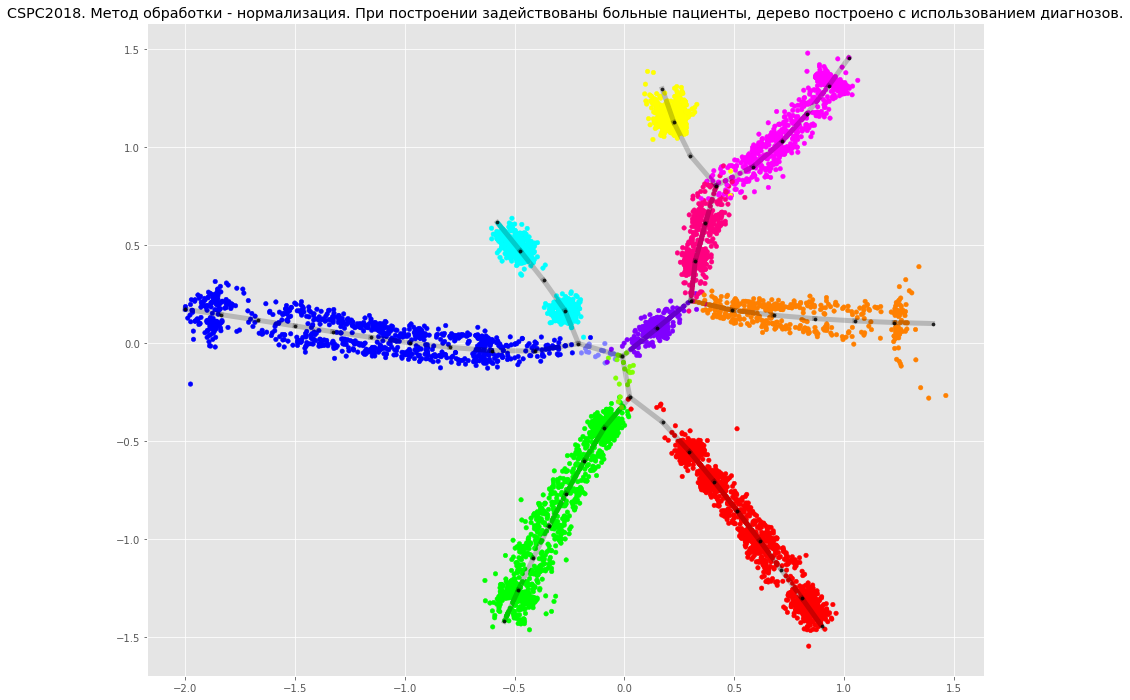

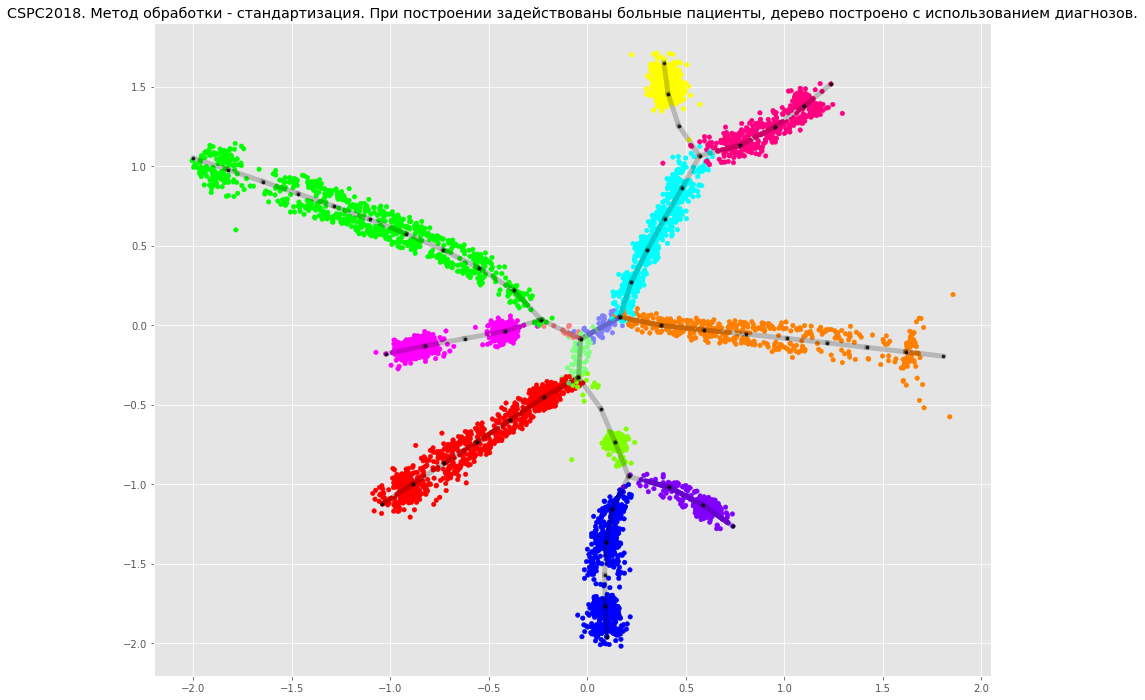

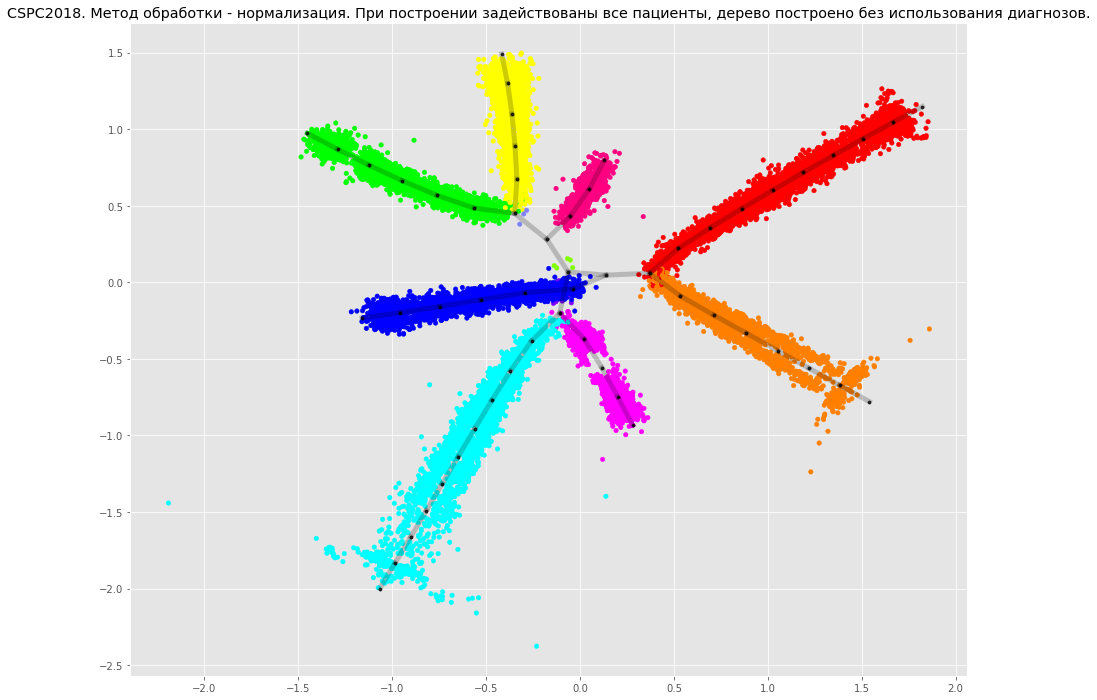

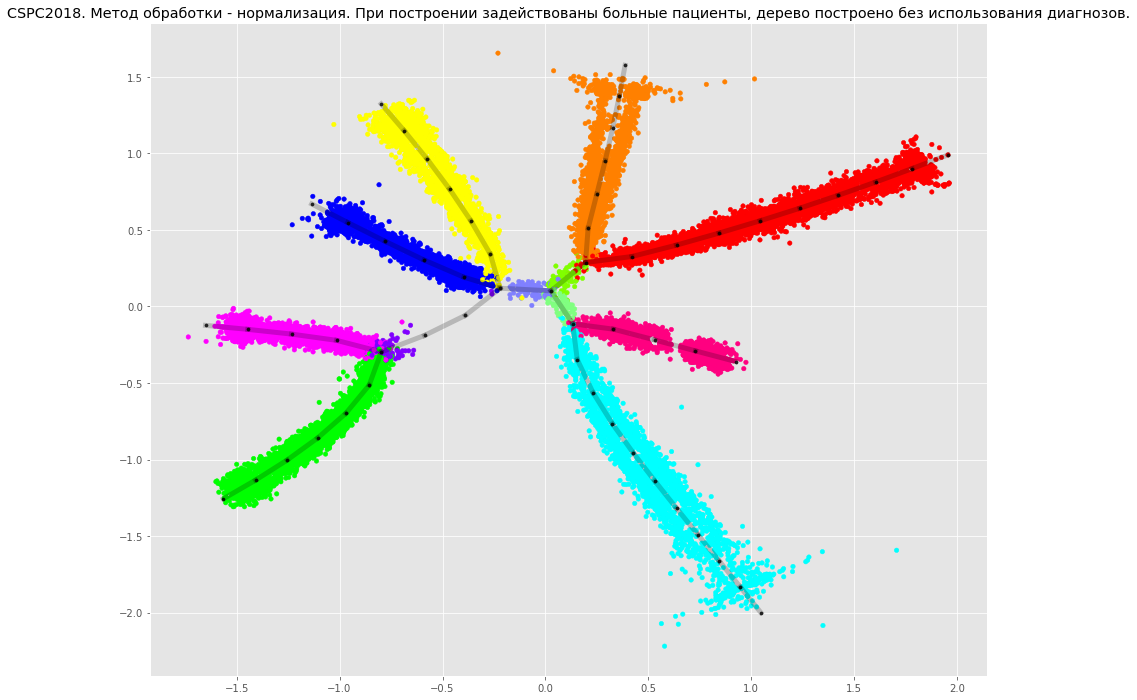

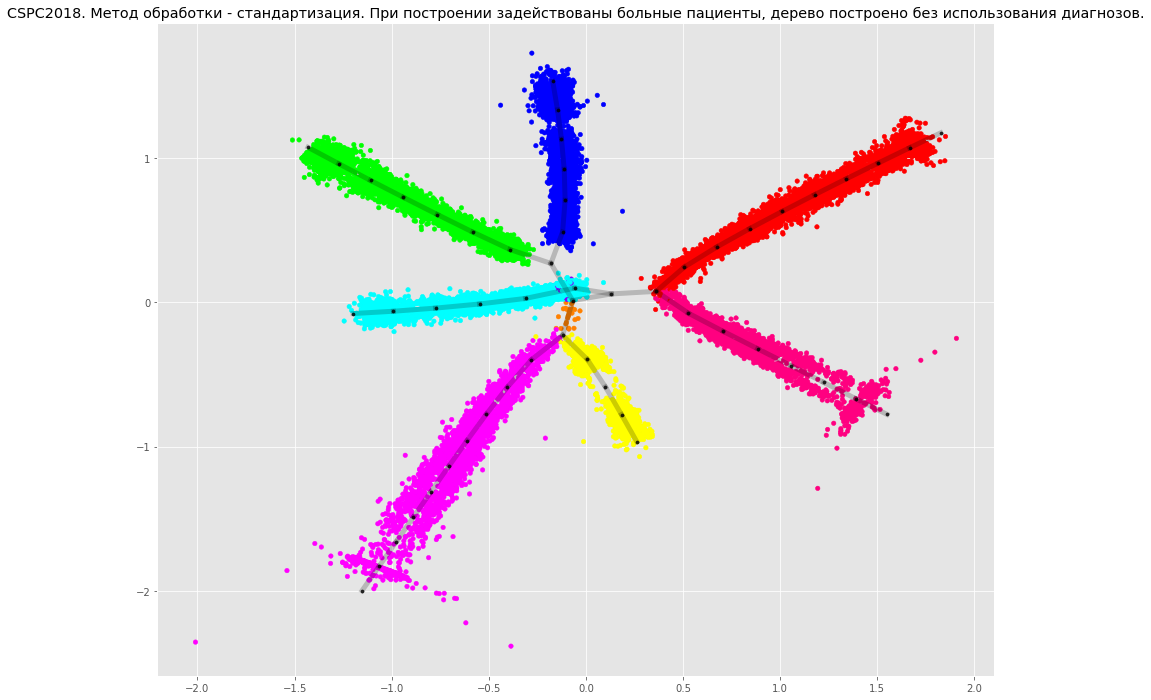

In [208]:
for i in range(4):
    for data in [data_for_cspc2018_tree_norm, data_for_cspc2018_tree_std]:
        fig = plt.figure(figsize=figsize)
        tree_visualization(data.tree_pack[i], data.pca_pack[i], data.dataset_orig_pack[i], 
                           data.components_pack[i], data.mnval_pack[i], data.var_names_pack[i])
        plt.title(f"{data.title} При построении задействованы {data.title_pack[i]}")
        plt.show()
    
    print("\n\n")

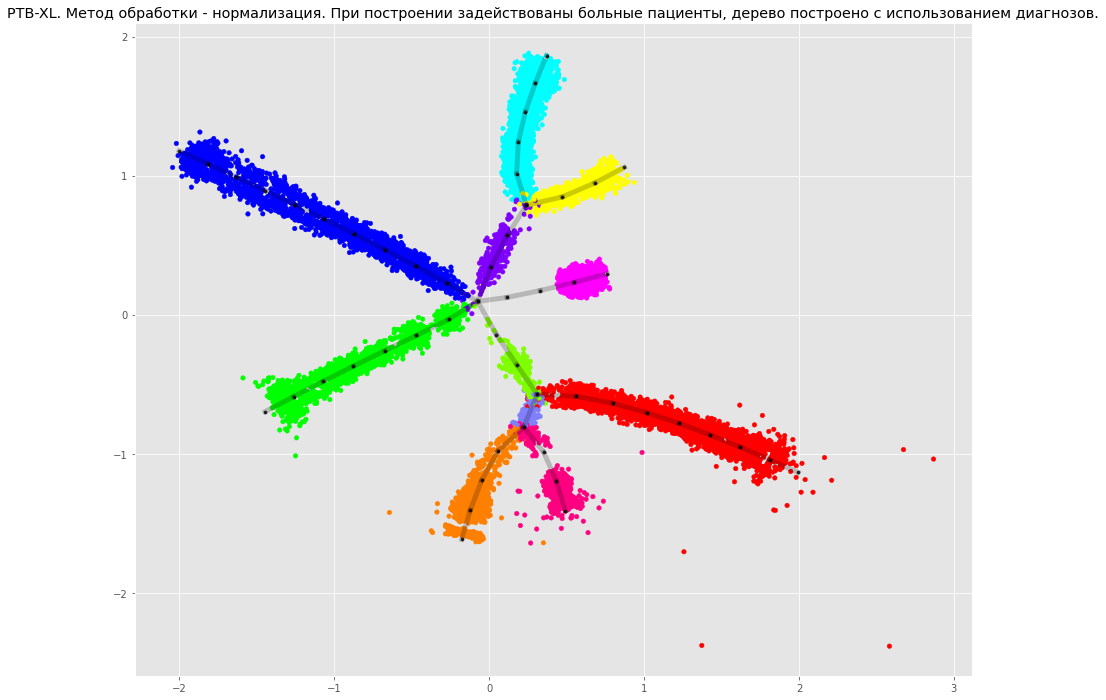

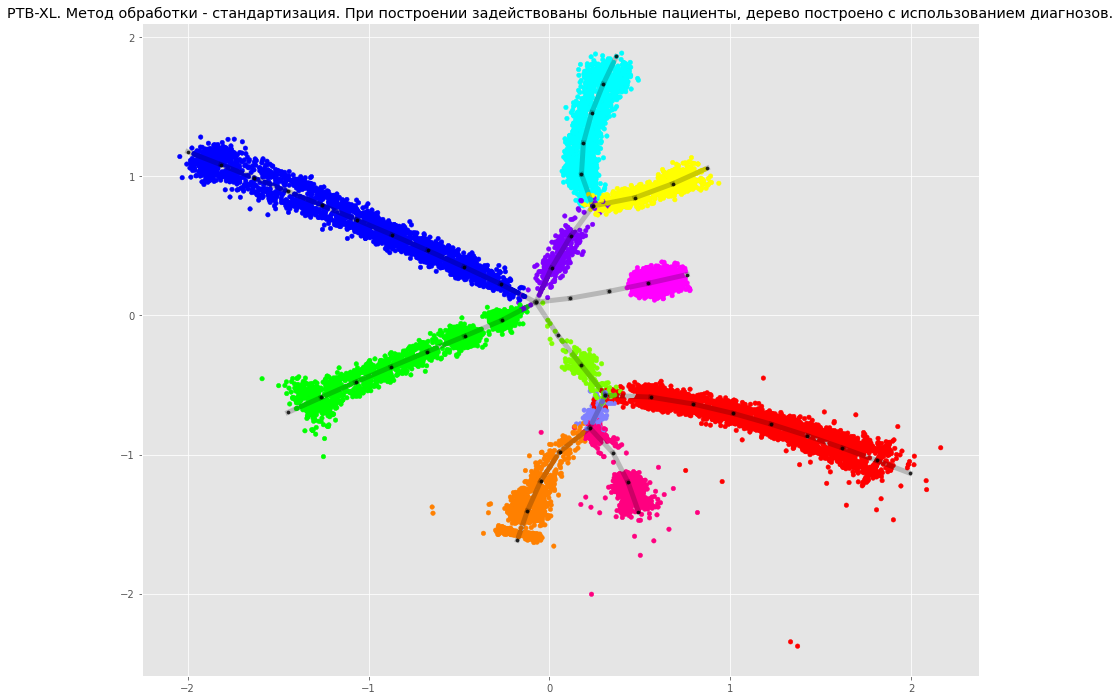

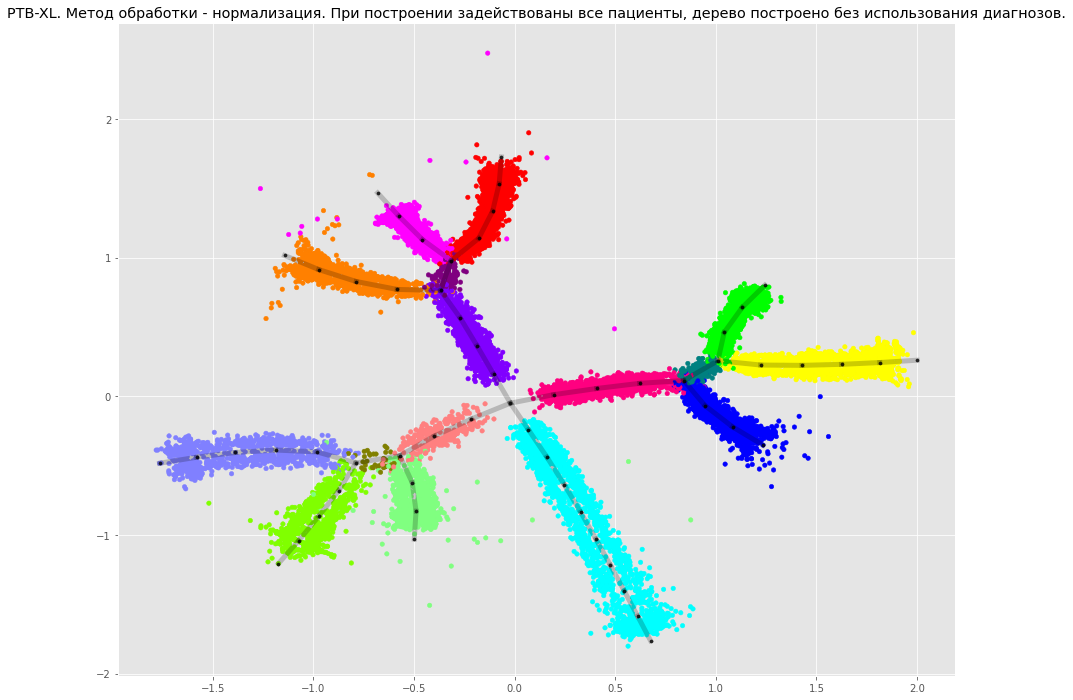

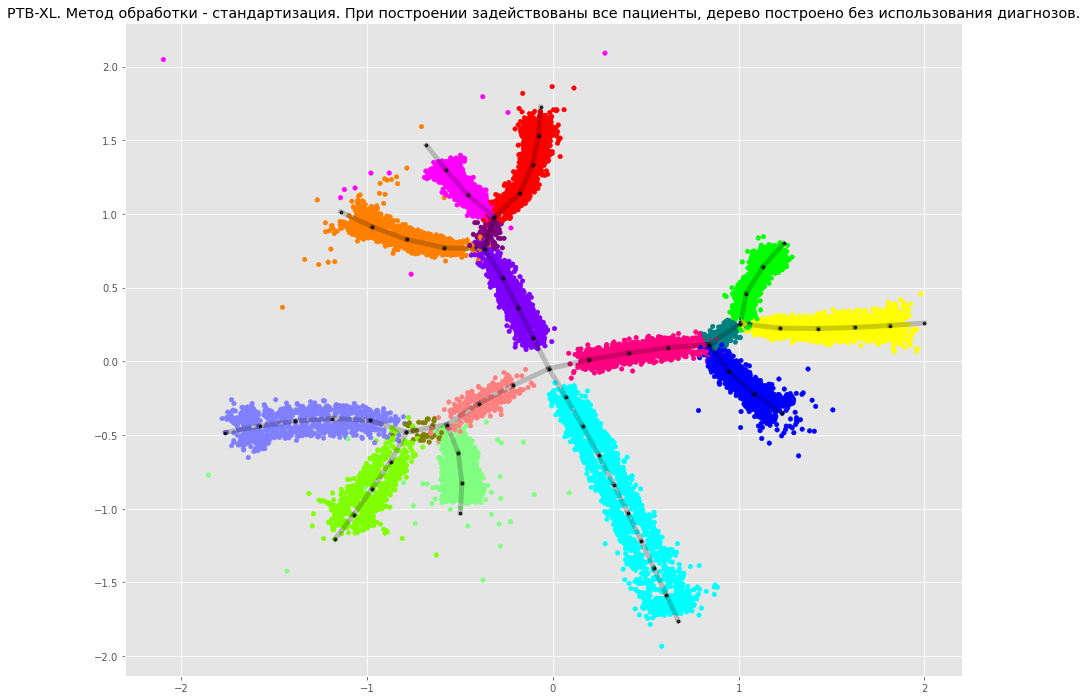

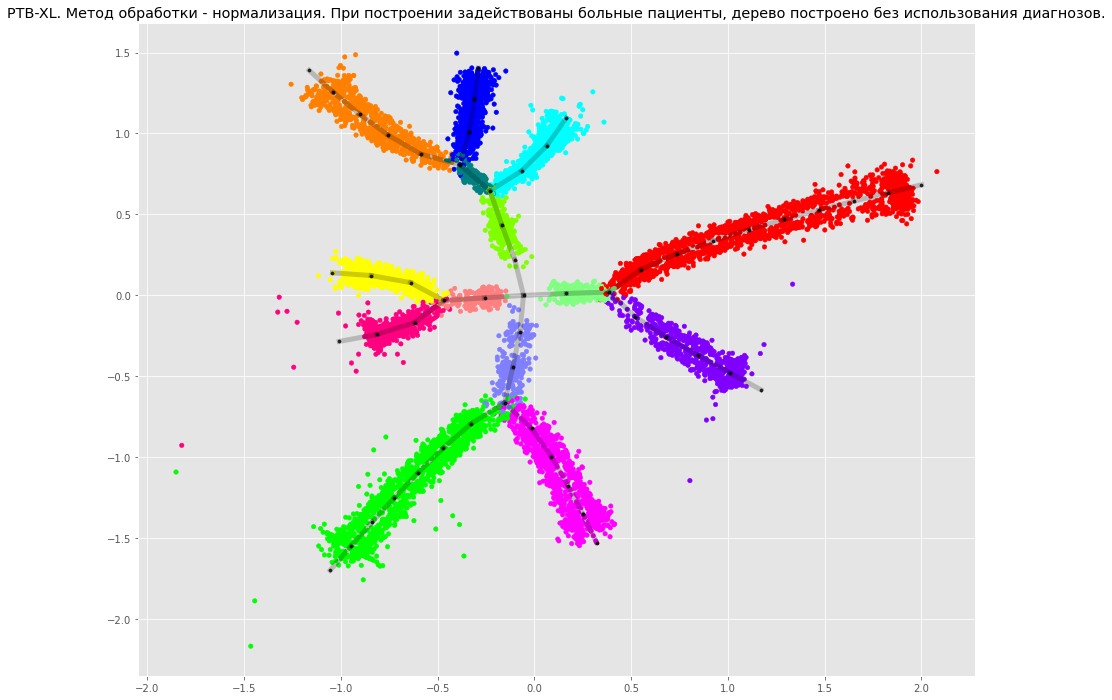

In [209]:
for i in range(4):
    for data in [data_for_ptb_xl_tree_norm, data_for_ptb_xl_tree_std]:
        fig = plt.figure(figsize=figsize)
        tree_visualization(data.tree_pack[i], data.pca_pack[i], data.dataset_orig_pack[i], 
                           data.components_pack[i], data.mnval_pack[i], data.var_names_pack[i])
        plt.title(f"{data.title} При построении задействованы {data.title_pack[i]}")
        plt.show()
    
    print("\n\n")

Можем заметить, что выбор метода обработки (нормализации или стандартизации) практически не влияет на форму дерева. Пока что для дальнейших исследований будем использовать датасеты, обработанные с помощью нормализации.

### Визуализация атрибутов и исследование деревьев

#### Диагнозы

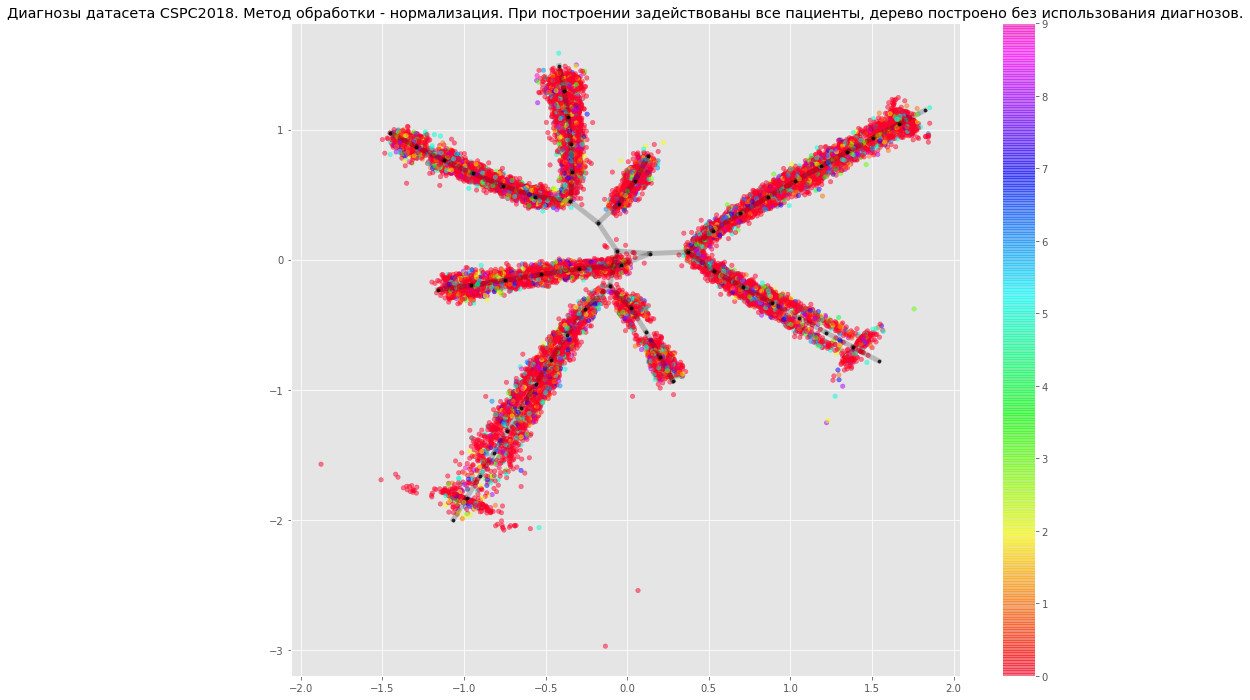

In [220]:
for i in range(4):
    data = data_for_cspc2018_tree_norm
    fig = plt.figure(figsize=figsize)
    visualize_eltree_with_data(data.tree_pack[i], data.pca_pack[i], data.dataset_orig_pack[i], 
                               data.components_pack[i], data.mnval_pack[i], 'k', data.var_names_pack[i],
                               Color_by_feature='f_label', cmap='gist_rainbow', add_color_bar=True, 
                               Transparency_Alpha_points = 0.5)
    plt.title(f"Диагнозы из датасета {data.title} При построении задействованы {data.title_pack[i]}")
    plt.show()
    
    fig = plt.figure(figsize=figsize)
    visualize_eltree_with_data(data.tree_pack[i], data.pca_pack[i], data.dataset_orig_pack[i], 
                               data.components_pack[i], data.mnval_pack[i], 'k', data.var_names_pack[i],
                               Color_by_feature='age', cmap='gist_rainbow', add_color_bar=True, 
                               Transparency_Alpha_points = 0.5)
    plt.title(f"Возраст пациентов из датасета {data.title} При построении задействованы {data.title_pack[i]}")
    plt.show()
    
    print("\n\n")

Видим, что наличие здоровых пациентов серьезно затрудняет анализ построенного дерева, так как здоровые пациенты располагаются практически на всех ветвях. Это связано с тем, что здоровых пациентов в датасете гораздо больше, чем больных.

В то же время при отсутствии здоровых пациентов можно выделить некоторые зависимости. На отдельных ветвях видно, что по мере продвижения по ветви классы аритмии равномерно перетекают из одного в другой (особенно при использовании диагнозов для построения дерева).

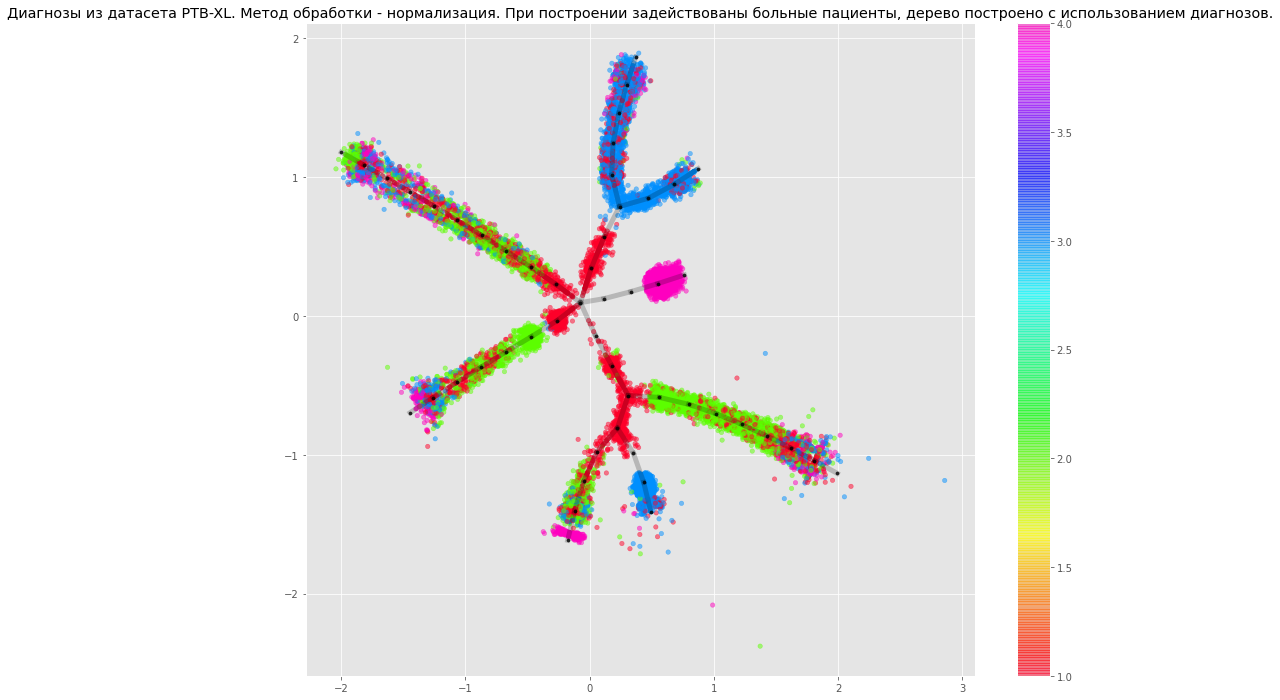

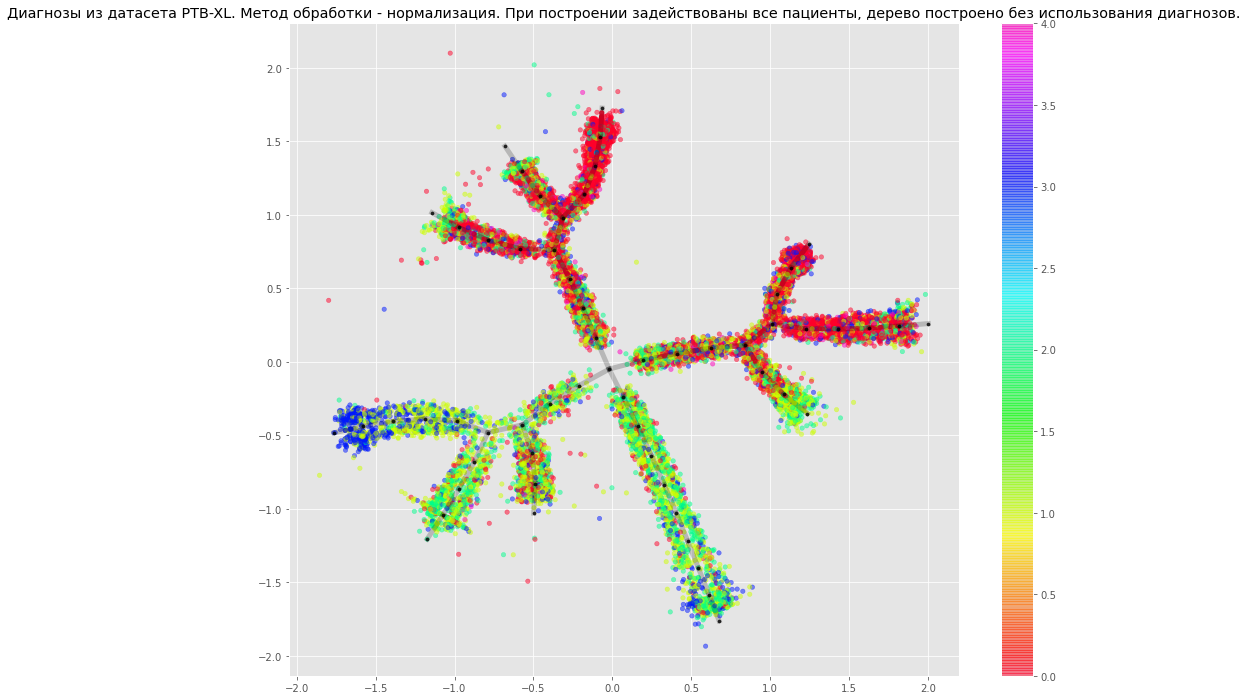

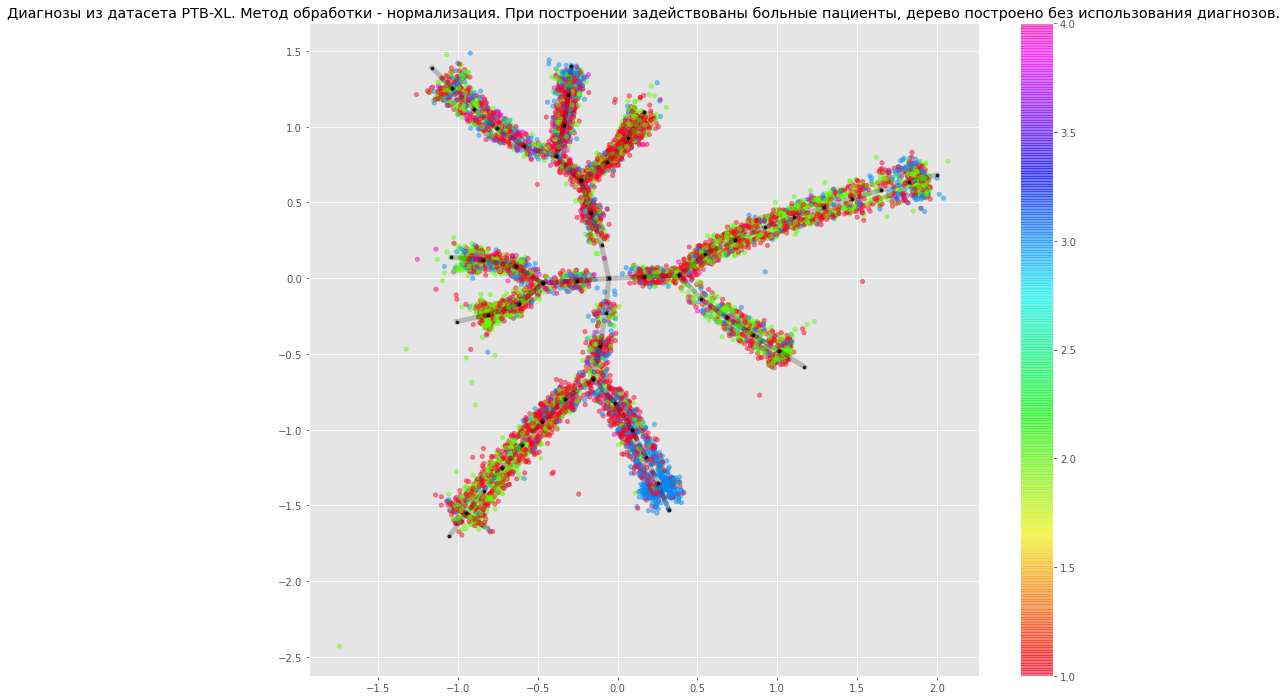

In [224]:
for i in range(4):
    data = data_for_ptb_xl_tree_norm
    fig = plt.figure(figsize=figsize)
    visualize_eltree_with_data(data.tree_pack[i], data.pca_pack[i], data.dataset_orig_pack[i], 
                               data.components_pack[i], data.mnval_pack[i], 'k', data.var_names_pack[i],
                               Color_by_feature='CLASS', cmap='gist_rainbow', add_color_bar=True, 
                               Transparency_Alpha_points = 0.5)
    plt.title(f"Диагнозы из датасета {data.title} При построении задействованы {data.title_pack[i]}")
    plt.show()
    
    print("\n\n")

Здесь все обстоит иначе. При использовании диагнозов в построении некоторые ветви дерева соответствуют какому-то конкретному диагнозу. В других же ветвях наблюдается плавный переход от одних диагнозов к другим, как и в ветвях деревьев, построенных без использования диагнозов.

#### Возраст пациентов

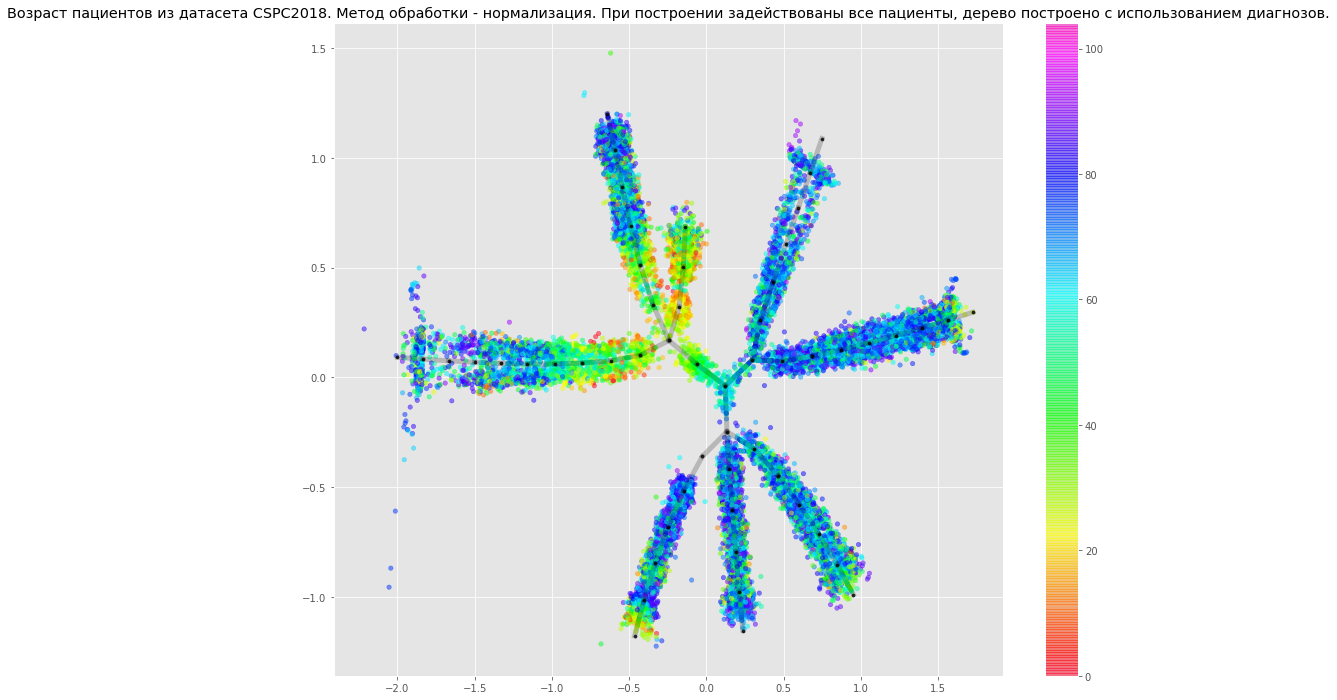

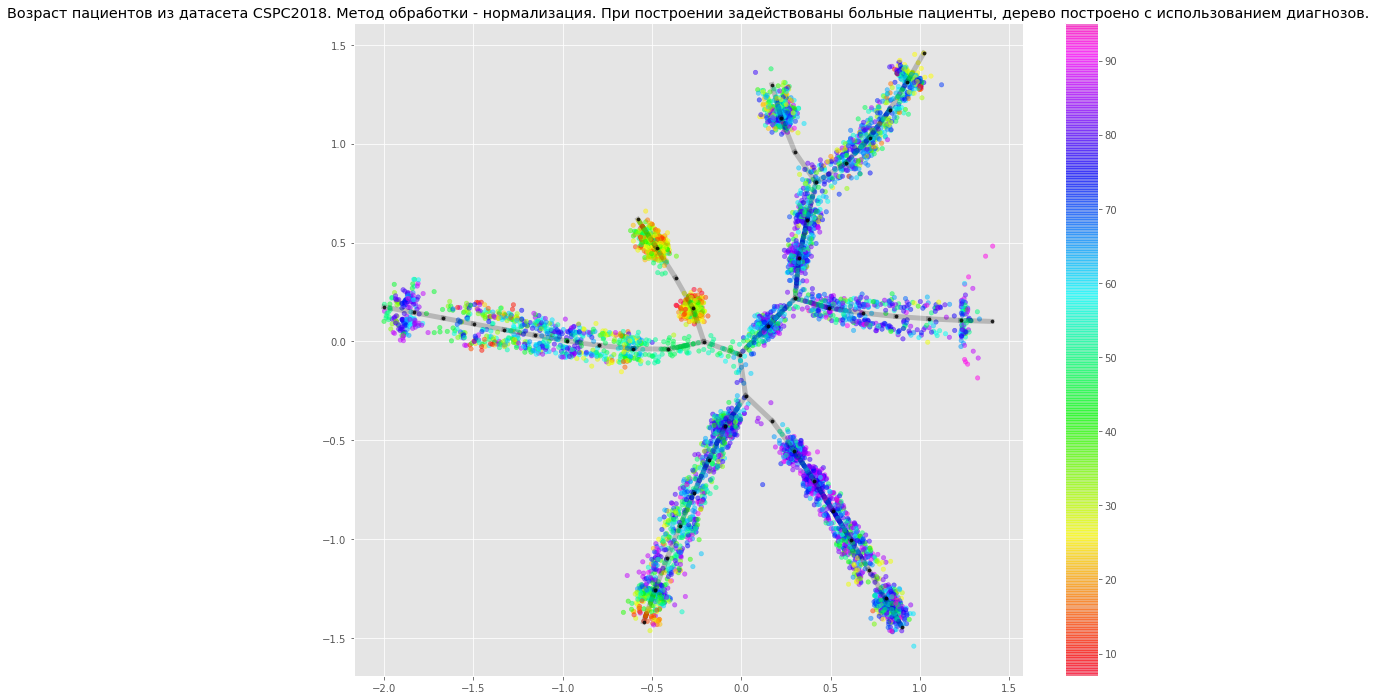

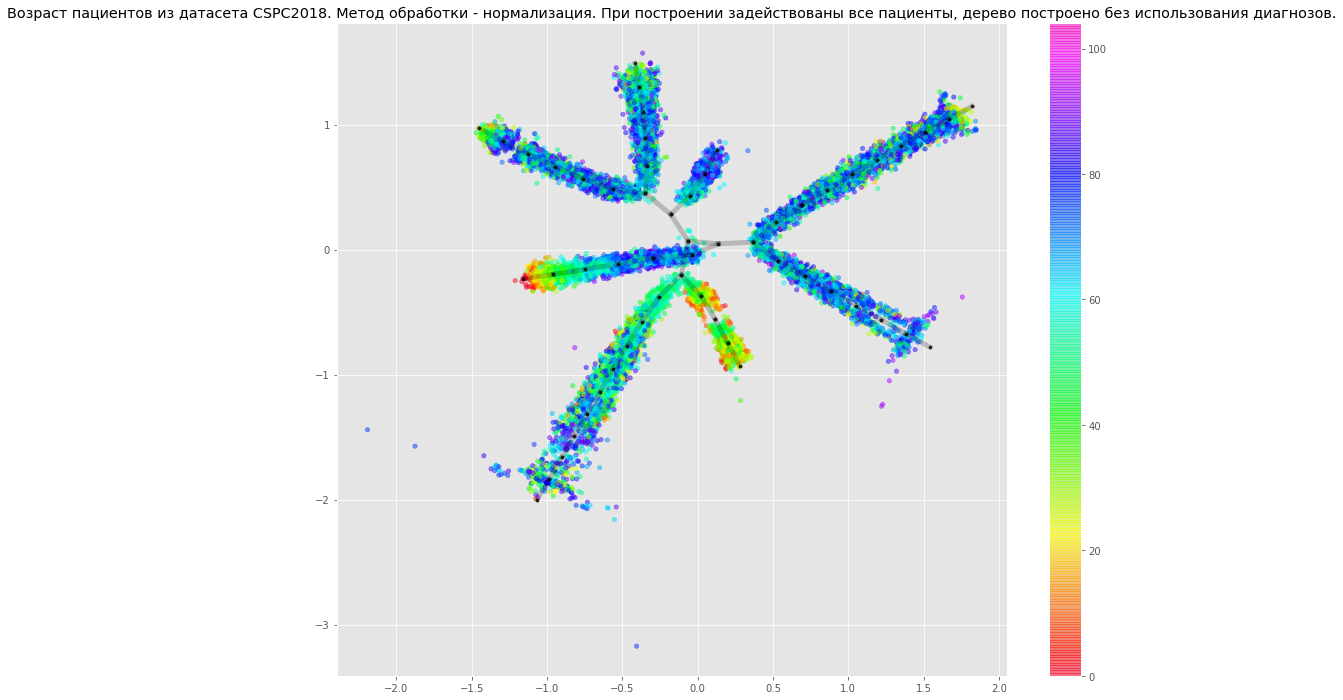

In [222]:
for i in range(4):
    data = data_for_cspc2018_tree_norm
    fig = plt.figure(figsize=figsize)
    visualize_eltree_with_data(data.tree_pack[i], data.pca_pack[i], data.dataset_orig_pack[i], 
                               data.components_pack[i], data.mnval_pack[i], 'k', data.var_names_pack[i],
                               Color_by_feature='age', cmap='gist_rainbow', add_color_bar=True, 
                               Transparency_Alpha_points = 0.5)
    plt.title(f"Возраст пациентов из датасета {data.title} При построении задействованы {data.title_pack[i]}")
    plt.show()
    
    print("\n\n")

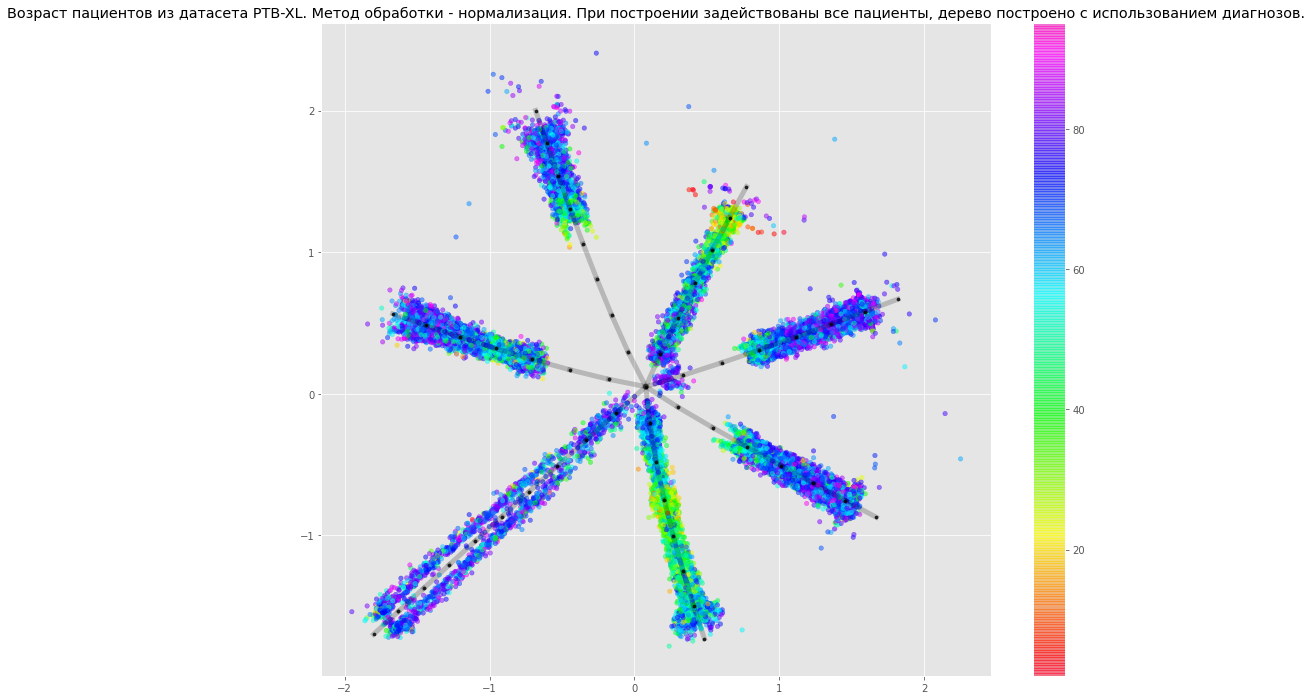

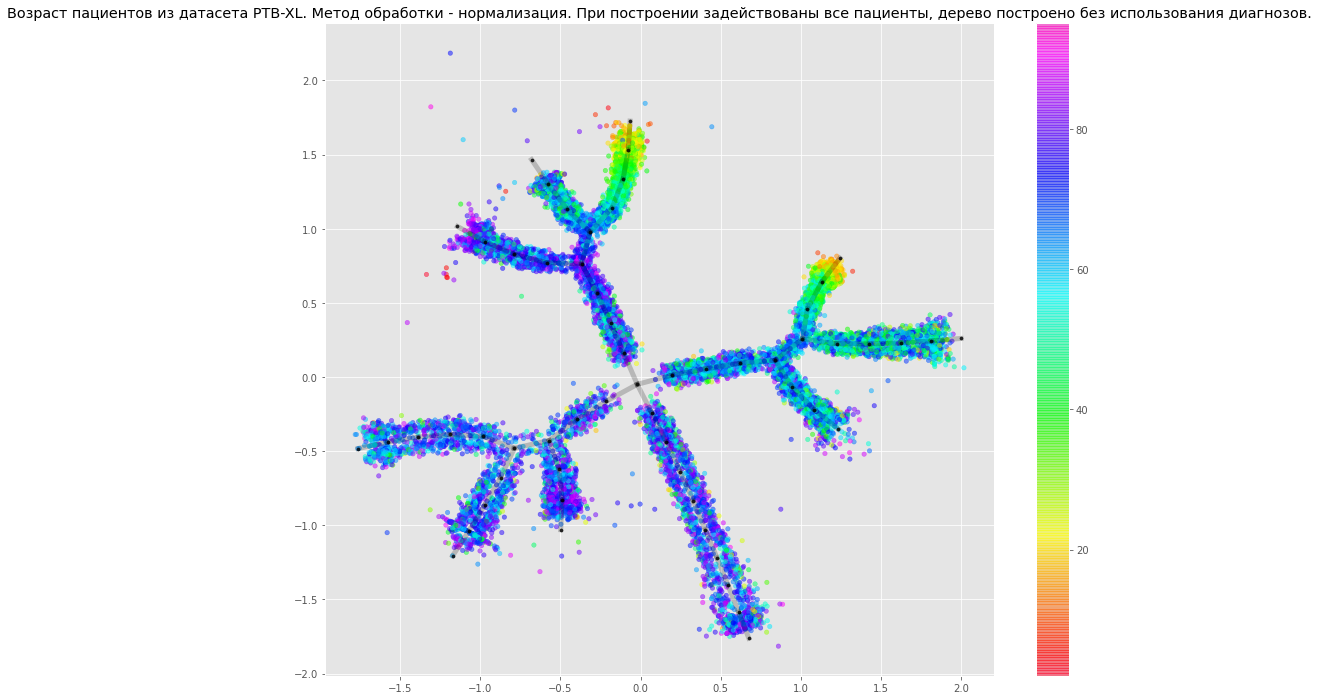

In [227]:
for i in range(4):
    data = data_for_ptb_xl_tree_norm
    fig = plt.figure(figsize=figsize)
    visualize_eltree_with_data(data.tree_pack[i], data.pca_pack[i], data.dataset_orig_pack[i], 
                               data.components_pack[i], data.mnval_pack[i], 'k', data.var_names_pack[i],
                               Color_by_feature='AGE', cmap='gist_rainbow', add_color_bar=True, 
                               Transparency_Alpha_points = 0.5)
    plt.title(f"Возраст пациентов из датасета {data.title} При построении задействованы {data.title_pack[i]}")
    plt.show()
    
    print("\n\n")

На всех деревьях во многих ветвях наблюдается плавное изменение возраста при движении по ветви. В других же ветвях возраст пациентов остается приблизительно одинаковым. Также заметно, что средний возраст на большинстве ветвей - от 60 до 80 лет, и только на некоторых ветвях преобладают молодые люди. 

#### Сравнение диагнозов и возраста

Возьмем наиболее "удачные" визуализации диагнозов, и сравним их с визуализациями возрастов пациентов.

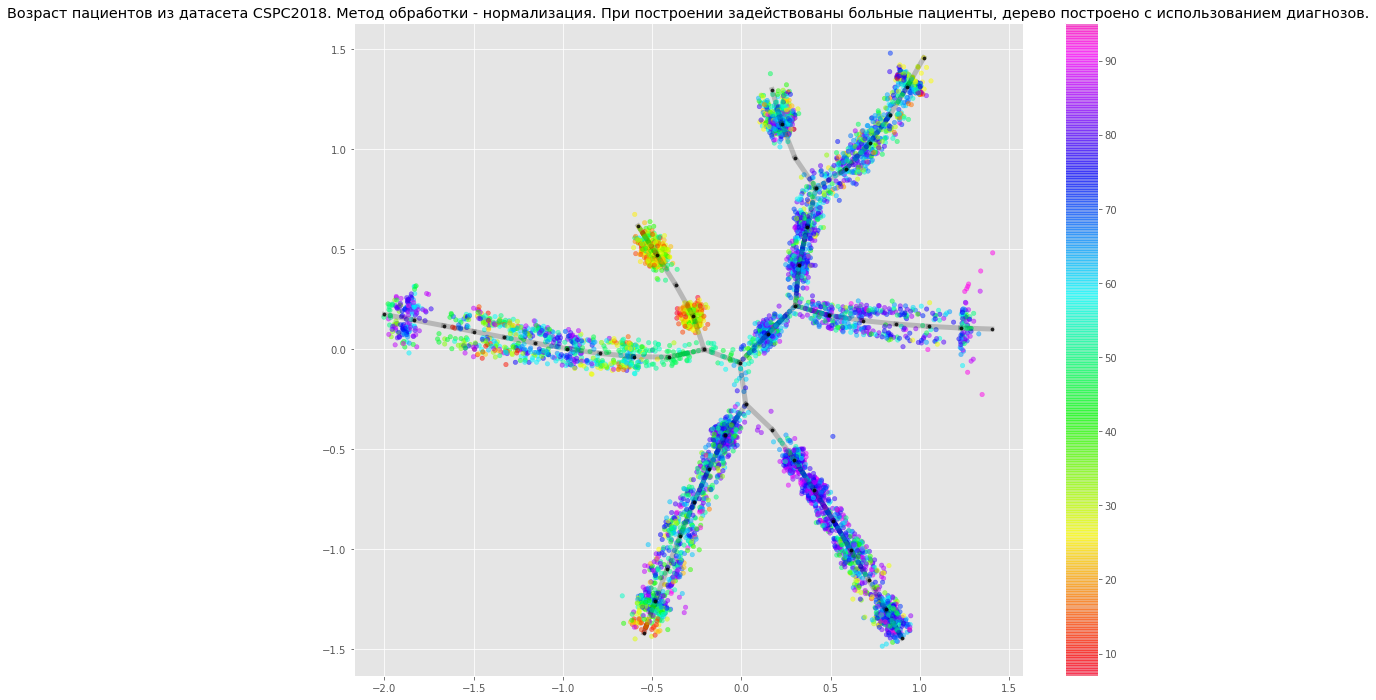

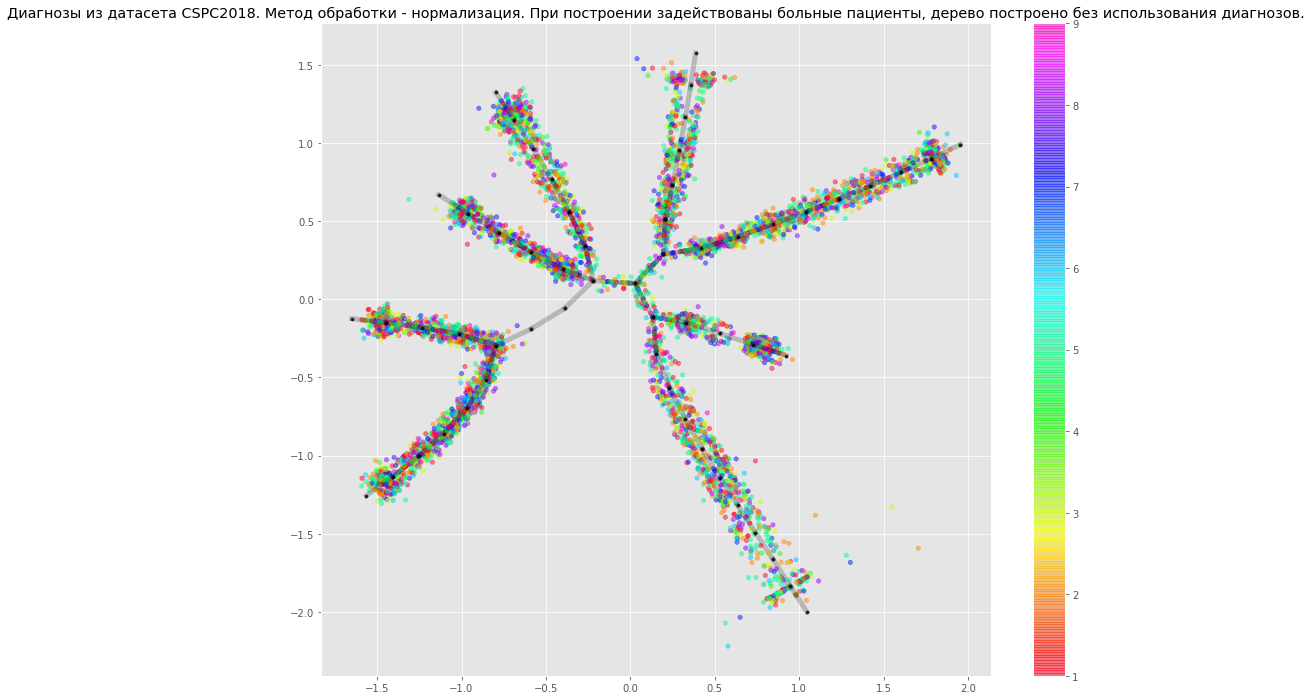

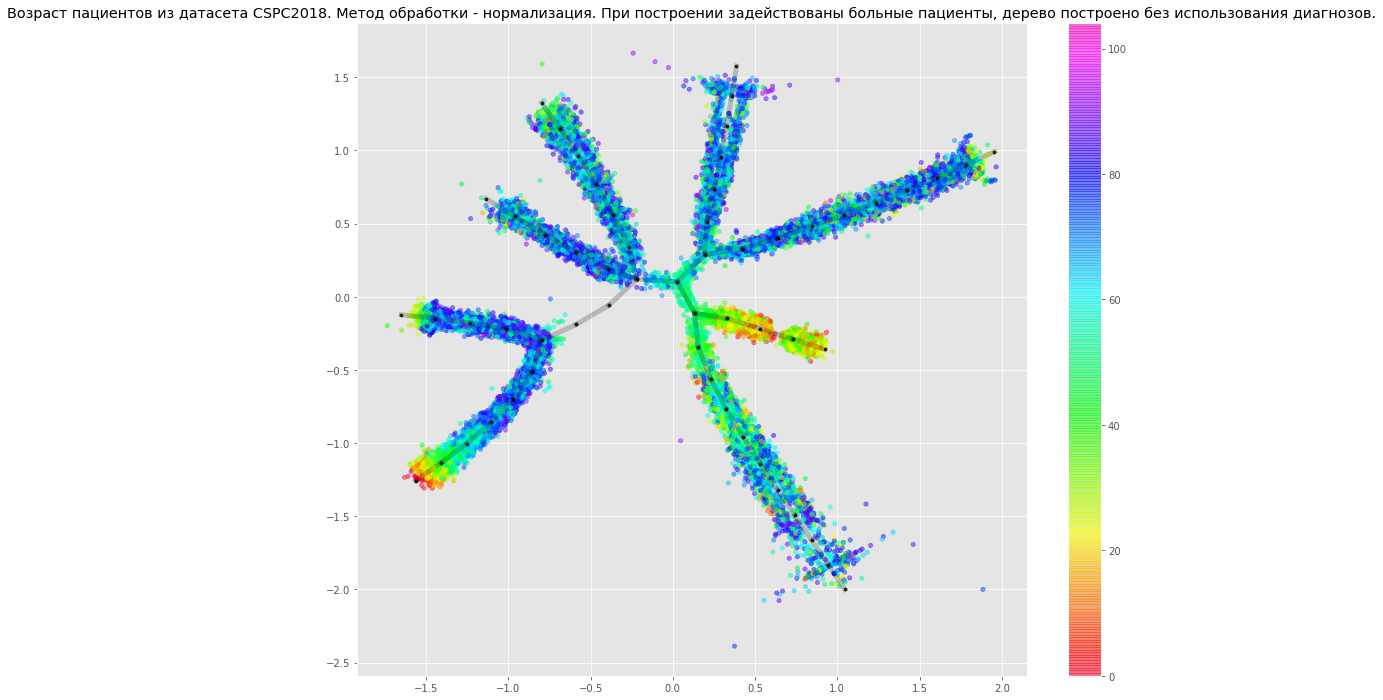

In [228]:
for i in [1, 3]:
    data = data_for_cspc2018_tree_norm
    fig = plt.figure(figsize=figsize)
    visualize_eltree_with_data(data.tree_pack[i], data.pca_pack[i], data.dataset_orig_pack[i], 
                               data.components_pack[i], data.mnval_pack[i], 'k', data.var_names_pack[i],
                               Color_by_feature='f_label', cmap='gist_rainbow', add_color_bar=True, 
                               Transparency_Alpha_points = 0.5)
    plt.title(f"Диагнозы из датасета {data.title} При построении задействованы {data.title_pack[i]}")
    plt.show()
    
    fig = plt.figure(figsize=figsize)
    visualize_eltree_with_data(data.tree_pack[i], data.pca_pack[i], data.dataset_orig_pack[i], 
                               data.components_pack[i], data.mnval_pack[i], 'k', data.var_names_pack[i],
                               Color_by_feature='age', cmap='gist_rainbow', add_color_bar=True, 
                               Transparency_Alpha_points = 0.5)
    plt.title(f"Возраст пациентов из датасета {data.title} При построении задействованы {data.title_pack[i]}")
    plt.show()
    
    print("\n\n")

Здесь видим, что первое дерево больше подходит для исследования зависимости "диагноз -> возраст", в то время как второе - наоборот, для исследования зависимости "возраст -> диагноз".